<a id='0'></a>
# Modeling and optimization for a 100% renewable electricity system for South Korea

### Contents
- [1 Import libraries](#1)
- [2 Land Eligibility](#2)
    - [2.1 Import data](#2.1)
    - [2.2 Grouping Provinces](#2.2)
    - [2.3 Split of maritime region](#2.3)
    - [2.4 Exclude and include eligible inland territories for onwind generation.](#2.4)
    - [2.5 Exclude and include eligible inland territories for offwind generation.](#2.5)
    - [2.6 Exclude and include eligible inland territories for solar generation.](#2.6)
- [3 Calculation and Plotting of Land Eligibility](#3)
    - [3.1 Funtions for plotting and calculation](#3.1)
    - [3.2 Calculation and plotting for the corresponding technology.](#3.2)
    - [3.3 ERA5 inland weather data collection.](#3.3)
    - [3.4 ERA5 maritime weather data collection](#3.4)
    - [3.5 Deployment and profiles creation.](#3.5)
- [4 Building network data.](#4)
    - [4.1 Data frames creation for the profiles.](#4.1)
    - [4.2  Power plants and separation by region. ](#4.2)
    - [4.3 Loading of population and Load.](#4.3)
    - [4.4 Building the pypsa network. ](#4.4)
    - [4.5 VOM and FOM cost addition.](#4.5)
- [5 Building the pypsa network](#5)
    - [5.1 Buses creation.](#5.1)
    - [5.2 Carreies loading.](#5.2)
    - [5.3 Building Generators.](#5.3)
    - [5.4 Links creation](#5.4)
- [6 Optimization of the network.](#6)
    - [6.1 Current Situation.](#6.1)
    - [6.2 Zero Co2 Emission.](#6.2)
    - [6.3 Renewable Energies only.](#6.3)
- [7 Sensitivity Analysis.](#7)
    - [7.1 Variations of solar potentials.](#7.1)
    - [7.2 Variations of offwind technology costs.](#7.2)
    - [7.3 Variations of nuclear cost.](#7.3)
    - [7.4 Variations of grid capacities.](#7.4)

<a id='1'></a>
# 1 Import libraries <font size=5>[&#x1F815;](#Contents)</font>

In [1]:
from atlite.gis import ExclusionContainer
from atlite.gis import shape_availability
import atlite
import rasterio as rio
from rasterio.plot import show
import geopandas as gpd
import pandas as pd
import numpy as np
import xarray as xr
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import country_converter as coco
import atlite
from pyproj import Proj, transform
import netCDF4 as nc
from urllib.request import urlretrieve
import warnings
warnings.filterwarnings("ignore")
from vresutils.graph import voronoi_partition_pts
import cartopy.crs as ccrs
import pypsa
import random
from pypsa.plot import add_legend_patches
import copy
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

|<a id='2'></a>
# 2 Land Eligibility <font size=5>[&#x1F815;](#Contents)</font>

<a id='2.1'></a>
## 2.1 Import data<font size=5>[&#x1F815;]()</font>

In [2]:
country = gpd.read_file("gadm_410-levels-ADM_1-KOR.gpkg") # Importing Land area

ocean = gpd.read_file("eez_v11.gpkg") # Importing ocean area
ocean_region_a = ocean[ocean.GEONAME == "South Korean Exclusive Economic Zone"] # Filtering for SK EEZ

In [3]:
# ocean_region_a.plot() #Ocean territory plot

In [4]:
# country.plot() # Land territory plot with all regions

<a id='2.2'></a>
## 2.2 Splitting Land Regions<font size=5>[&#x1F815;]()</font>

In [5]:
regions = country.copy() # Creating a dataframe copy of land to divide it into regions
regions["regions"]= [4,2,2,5,2,5,3,1,5,4,1,4,3,3,2,1,4] # Assigning number to each region that will combine
regions = regions.dissolve(by="regions") # Dissolving it by assigned regions
points = regions.representative_point() # Finding representative points

# Naming the regions
region_names = ['NW','CE','SW','SE','NE'] # Northwest, Central, Southwest, Southeast, Northeast
regions['Short_Name'] = region_names
regions.index = regions.Short_Name
provinces = regions
regions = regions[['geometry']]

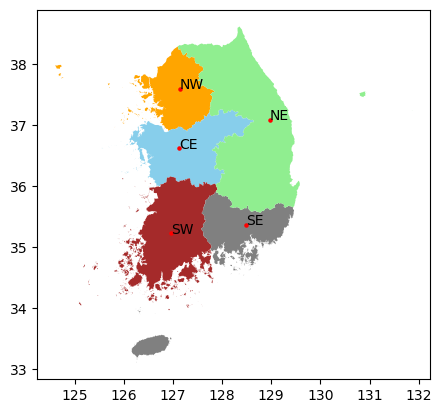

In [6]:
# Plotting the regions with representative points
colors = ( "orange", "skyblue", "brown", "grey", "lightgreen") # Assigning colours to each region
fig, ax = plt.subplots()
regions.reset_index().plot(ax=ax, column='Short_Name',color=colors)
points.plot(ax=ax, color='red', markersize=5);

for i, txt in enumerate(region_names):
    ax.annotate(txt, (points.x[i+1], points.y[i+1]))

<a id='2.3'></a>
## 2.3 Splitting EEZ regions<font size=5>[&#x1F815;]()</font>

In [7]:
eez_shape = ocean_region_a.geometry.iloc[0]

eez_split = gpd.GeoDataFrame(
{        "name": points.index,
        "geometry": voronoi_partition_pts(list(zip(points.x, points.y)), eez_shape) }
).set_index('name')
eez_split = eez_split.loc[eez_split.area > 1e-2]
eez_split['Short_Name'] = region_names
eez_split.index = eez_split.Short_Name
eez_split = eez_split.drop(columns=['Short_Name'])
ocean_region = eez_split.copy()

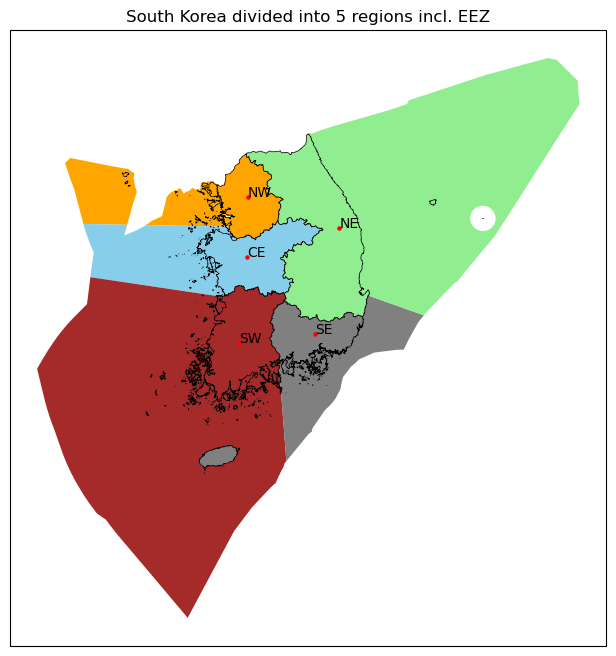

In [8]:
# Plotting both Land and EEZ region together

fig = plt.figure(figsize=(8,8))
colors = ( "orange", "skyblue", "brown",
          "grey", "lightgreen")
ax = plt.axes(projection=ccrs.EqualEarth())
eez_split.reset_index().plot(ax=ax, column='Short_Name', color = colors)
regions.reset_index().plot(ax=ax, linewidth=0.5, edgecolor='k', column='Short_Name', color = colors)
points.plot(ax=ax, color='red', markersize=5);
plt.title('South Korea divided into 5 regions incl. EEZ')

for i, txt in enumerate(region_names):
    ax.annotate(txt, (points.x[i+1], points.y[i+1]))

In [9]:
# Setting variables required for calculations

# Only for area calculations
AREA_CRS = "ESRI:54009"

korea_1 = country.dissolve(by='COUNTRY').to_crs(crs=4087)
korea_2 = country.dissolve(by='COUNTRY').to_crs(AREA_CRS)
korea = korea_1['geometry'].item()
korea1 = korea_2['geometry'].item()

land_shape = regions.to_crs(4087).geometry
land_shape1 = land_shape.to_crs(AREA_CRS)

# ocean_region = ocean_region.set_crs(4087)
korea_ocean = ocean[ocean.GEONAME == "South Korean Exclusive Economic Zone"].to_crs(crs=4087)
korea_ocean = korea_ocean['geometry'].item()
korea_ocean1 = ocean[ocean.GEONAME == "South Korean Exclusive Economic Zone"].to_crs(AREA_CRS)
korea_ocean1 = korea_ocean1['geometry'].item()

ocean_region = ocean_region.set_crs(4326)
ocean_shape = ocean_region.to_crs(4087).geometry
ocean_shape1 = ocean_shape.to_crs(AREA_CRS) # Only for area calculations

<a id='2.4'></a>
## 2.4 Exclude and include eligible inland territories for onwind generation. <font size=5>[&#x1F815;]()</font>

In [10]:
 # Creating an exclusion container with the land eligibility constraints for Onshore Wind
onshore_excluder = ExclusionContainer(crs=4087, res=300)

# Geometry Exclusions
onshore_excluder.add_geometry("ne_10m_roads.gpkg", buffer=300) #Exclusion for Major Roads with 300m buffer
onshore_excluder.add_geometry("ne_10m_airports.gpkg", buffer=10000) #Exclusion for Airports with 10km buffer

# Exclusion for Land Cover (copernicus-glc)
fn = 'PROBAV_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-map_EPSG-4326-KR.tif'
onshore_excluder.add_raster(fn, codes=lambda x: x>2000, crs=4326) #Exclude elevation over 2000m
onshore_excluder.add_raster(fn, codes=[50], buffer=1000, crs=4326) #1000m to built-up areas
onshore_excluder.add_raster(fn, codes=[20,30,40,60], crs=4326, invert=True) #Including suitable land cover classes (Need to confirm if codes are correct)

# Exclusion for natural protection areas (wdpa)
fn = 'WDPA_Oct2022_Public_shp-KOR.tif'
onshore_excluder.add_raster(fn, crs=3035)

In [11]:
# Creating a separate exclusion container with a different CRS for area calculations
onshore_excluder1 = copy.copy(onshore_excluder)
onshore_excluder1.crs = AREA_CRS

<a id='2.5'></a>
## 2.5 Exclude and include eligible maritime territories for offwind generation. <font size=5>[&#x1F815;]()</font>

In [12]:
 # Creating an exclusion container with the ocean eligibility constraints for Offshore Wind
ocean_excluder = ExclusionContainer(crs=4087, res=300)

fn = 'GEBCO_2014_2D-KR.nc'
ocean_excluder.add_raster(fn, codes=lambda x: x<(-50), crs=4326) # Exclude depths over 50m
ocean_excluder.add_geometry(korea_1, buffer = 10000) # 10km min distance to shoreline
ocean_excluder.add_geometry('eez_boundaries_v11.gpkg') # Within EEZ boundaries

# Exclusion for natural protection areas (wdpa)
fn = f'WDPA_Oct2022_Public_shp-KOR.tif'
ocean_excluder.add_raster(fn, crs=3035) # Changed crs from 4085 to 3035..Confirm?

In [13]:
ocean_excluder1 = copy.copy(ocean_excluder)
ocean_excluder1.crs = AREA_CRS

<a id='2.6'></a>
## 2.6 Exclude and include eligible inland territories for solar generation. <font size=5>[&#x1F815;]()</font>

In [14]:
 # Creating an exclusion container with the land eligibility constraints for Solar
solar_excluder = ExclusionContainer(crs=4087, res=300)

# Raster Exclusion for Land Cover (copernicus-glc)
fn = 'PROBAV_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-map_EPSG-4326-KR.tif'
solar_excluder.add_raster(fn, codes=[20,30,40,60], crs=4326, invert=True) # Including suitable land cover classes (Need to confirm if codes are correct)

# Raster Exclusion for natural protection areas (wdpa)
fn = 'WDPA_Oct2022_Public_shp-KOR.tif'
solar_excluder.add_raster(fn, crs=3035)

In [15]:
solar_excluder1 = copy.copy(solar_excluder)
solar_excluder1.crs = AREA_CRS

<a id='3'></a>
# 3 Calculation and Plotting of Land Eligibility <font size=5>[&#x1F815;](#Contents)</font>


<a id='3.1'></a>
## 3.1 Funtions for plotting and calculation. <font size=5>[&#x1F815;]()</font>

In [16]:
# Function to plot land eligibility plots
def plot_area(masked, transform, shape): # Function takes 3 inputs: Masked, Transform, Shape
    fig, ax = plt.subplots(figsize=(6,6))
    ax = show(masked, transform=transform, cmap='Greens', vmin=0, ax=ax)
    shape.plot(ax=ax, edgecolor='k', color='None', linewidth=1)

In [17]:
# Function to calculate Eligible Area
def elig_area(masked, excluder, region): # Function takes 3 inputs: Masked, Excluder, Region (Land/Ocean)
    eligible_cells = np.int64(masked.sum())
    cell_area = excluder.res**2
    eligible_area = cell_area * eligible_cells
    total_area = region.area
    percent_area = (eligible_area / total_area) * 100
    return percent_area, eligible_area

In [18]:
def area_calc(land_shape, excluder):
    area_percent = []
    available_area = []
    x = 0
    y = 1

    for i in land_shape.index:
        masked, transform = shape_availability(land_shape[x:y], excluder)
        arp, ar = elig_area(masked, excluder, land_shape[x:y])
        area_percent.append(arp.item())
        available_area.append(ar)
        x = x+1
        y = y+1

    available_area = [i / 1e6 for i in available_area]
    df = pd.DataFrame()
    df['Short_Name'] = region_names
    df['Area km2'] = available_area
    df['Area_Percent'] = area_percent
    df = df.set_index('Short_Name')
    df['Cap per region'] = df['Area km2'] * 3 # MW/km2

    return df

<a id='3.2'></a>
## 3.2 Calculation and plotting for the corresponding technology. <font size=5>[&#x1F815;]()</font>

In [19]:
# For Area calculations for each region we will use shapes and exclusion containers with CRS "ESRI:54009"

In [20]:
solar_areas = area_calc(land_shape1, solar_excluder1)

In [21]:
onshore_areas = area_calc(land_shape1, onshore_excluder1)

In [22]:
offshore_areas = area_calc(ocean_shape1, ocean_excluder1)

For Onshore, 2698.8 km2 is available, which is 2.68% of South Korea Land


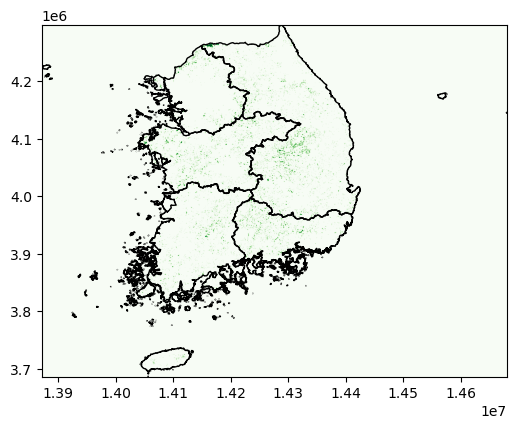

In [23]:
# Plotting onshore land eligibility
onshore_masked, onshore_transform = shape_availability(land_shape, onshore_excluder)
onshore_masked1, onshore_transform1 = shape_availability(land_shape1, onshore_excluder1)

percent_area, eligible_area = elig_area(onshore_masked1, onshore_excluder1, korea1)
print(f'For Onshore, {eligible_area/1e6:0.1f} km2 is available, which is {percent_area:0.2f}% of South Korea Land')

plot_area(onshore_masked, onshore_transform, land_shape)

For Offshore, 12849.8 km2 is available, which is 3.69% of South Korea EEZ


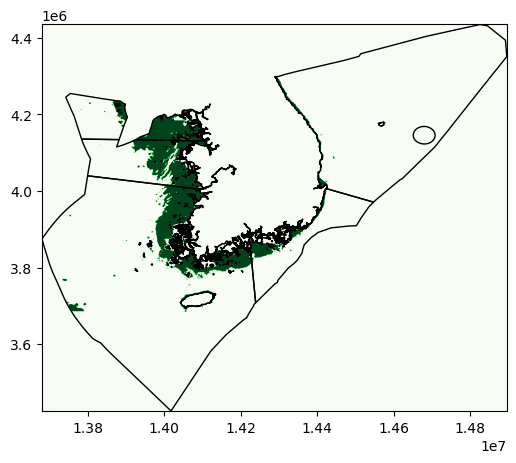

In [24]:
# Plotting offshore land eligibility
ocean_masked, ocean_transform = shape_availability(ocean_shape, ocean_excluder)
ocean_masked1, ocean_transform1 = shape_availability(ocean_shape1, ocean_excluder1)

percent_area, eligible_area = elig_area(ocean_masked1, ocean_excluder1, korea_ocean1)
print(f'For Offshore, {eligible_area/1e6:0.1f} km2 is available, which is {percent_area.item():0.2f}% of South Korea EEZ')

plot_area(ocean_masked, ocean_transform, ocean_shape)

For Solar, 16478.5 km2 is available, which is 16.36% of South Korea Land


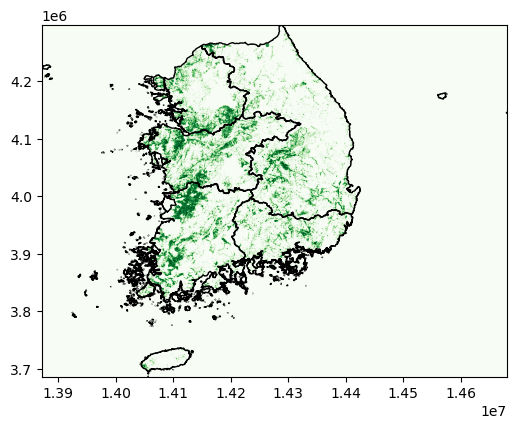

In [25]:
# Plotting solar land eligibility
solar_masked, solar_transform = shape_availability(land_shape, solar_excluder)
solar_masked1, solar_transform1 = shape_availability(land_shape1, solar_excluder1)

percent_area, eligible_area = elig_area(solar_masked1, solar_excluder1, korea1)
print(f'For Solar, {eligible_area/1e6:0.1f} km2 is available, which is {percent_area:0.2f}% of South Korea Land')

plot_area(solar_masked, solar_transform, land_shape)

<a id='3.3'></a>
## 3.3 ERA5 inland weather data collection. <font size=5>[&#x1F815;]()</font>

In [26]:
#UNCOMMENT BEFORE TURNING IN

# specify spatial extent
minx, miny, maxx, maxy = regions.total_bounds
buffer = 0.25

cutout = atlite.Cutout(
   path="southkorea_2020.nc",
   module="era5",
   x=slice(minx-buffer, maxx+buffer),
   y=slice(miny-buffer, maxy+buffer),
   time="2020",
)

In [27]:
#UNCOMMENT BEFORE TURNING IN

#initiate download and processing of weather data provided by CDS servgers. May take awhile
# cutout.prepare()

<a id='3.4'></a>
## 3.4 ERA5 maritime weather data collection. <font size=5>[&#x1F815;]()</font>

In [28]:
# #THIS SHOULD ALSO BE PREPARED IN ANOTHER FILE?

#specify spatial extent
ocean_minx, ocean_miny, ocean_maxx, ocean_maxy = ocean_region.total_bounds
buffer = 0.25

# #creating South Korean maritime cutout
ocean_cutout = atlite.Cutout(
   path="southkorean_ocean_2020.nc",
   module="era5",
   x=slice(ocean_minx-buffer, ocean_maxx+buffer),
   y=slice(ocean_miny-buffer, ocean_maxy+buffer),
   time="2020",
)

In [29]:
# #UNCOMMENT BEFORE TURNING IN

# #initiate download and processing of weather data provided by CDS servgers. May take awhile
# ocean_cutout.prepare()

In [30]:
onshore_A = cutout.availabilitymatrix(regions, onshore_excluder)
offshore_A = ocean_cutout.availabilitymatrix(ocean_region, ocean_excluder)
solar_A = cutout.availabilitymatrix(regions, solar_excluder)

Compute availability matrix: 100%|███████████████████████████████████████████████| 5/5 [00:05<00:00,  1.08s/ gridcells]


<a id='3.5'></a>
## 3.5 Deployment and profiles creation. <font size=5>[&#x1F815;]()</font>

In [31]:
#deployment density per square region (MW/km^2)
cap_per_sqkm = 3

#create area for cutout with coordinate scheme
area_onshore = cutout.grid.set_index(['y', 'x']).to_crs(4087).area / 1e6
area_offshore = ocean_cutout.grid.set_index(['y', 'x']).to_crs(4087).area / 1e6

#area to data array
area_onshore = xr.DataArray(area_onshore, dims=('spatial'))
area_offshore = xr.DataArray(area_offshore, dims=('spatial'))

#defining capacity matrix for profiles
onshore_capacity_matrix = onshore_A.stack(spatial=['y', 'x']) * area_onshore * cap_per_sqkm
ocean_capacity_matrix = offshore_A.stack(spatial=['y', 'x']) * area_offshore * cap_per_sqkm
solar_capacity_matrix = solar_A.stack(spatial=['y', 'x']) * area_onshore * cap_per_sqkm

In [32]:
#create onshore wind profiles
onshore = cutout.wind(
    atlite.windturbines.Vestas_V112_3MW,
    matrix=onshore_capacity_matrix,
    index=regions.index,
    per_unit=True,
)

onshore_df = onshore.to_pandas()

In [33]:
#create offshore wind profiles
offshore = ocean_cutout.wind(
    atlite.windturbines.NREL_ReferenceTurbine_5MW_offshore,
    matrix=ocean_capacity_matrix,
    index=ocean_region.index,
    per_unit=True,
)

offshore_df = offshore.to_pandas()

In [34]:
#create solar profile
solar = cutout.pv(
    panel=atlite.solarpanels.CdTe,
    matrix=solar_capacity_matrix,
    orientation='latitude_optimal',
    index=regions.index,
    per_unit=True,
)

solar_df = solar.to_pandas()

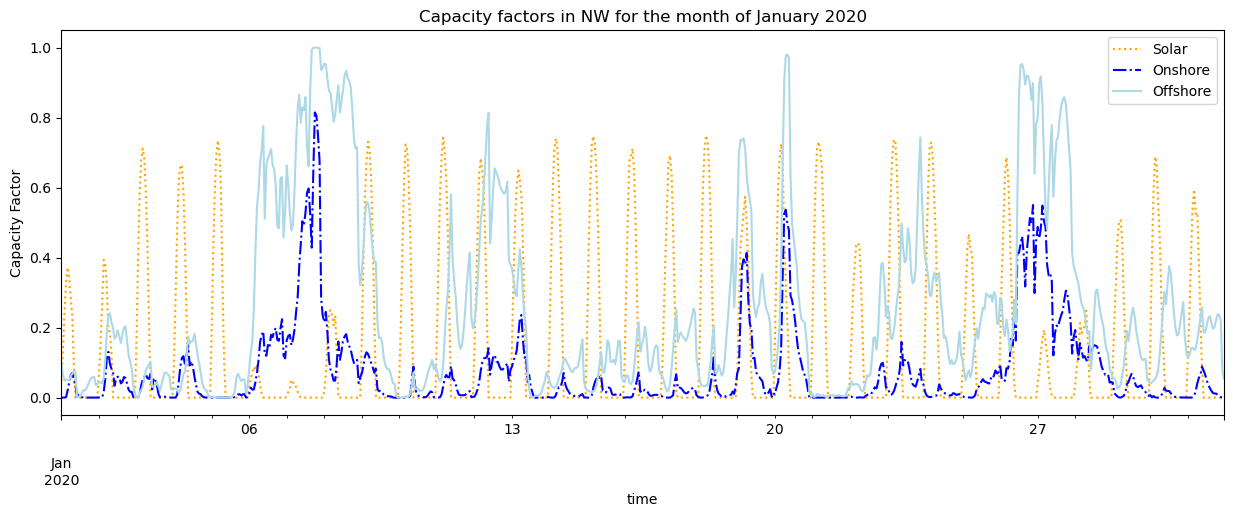

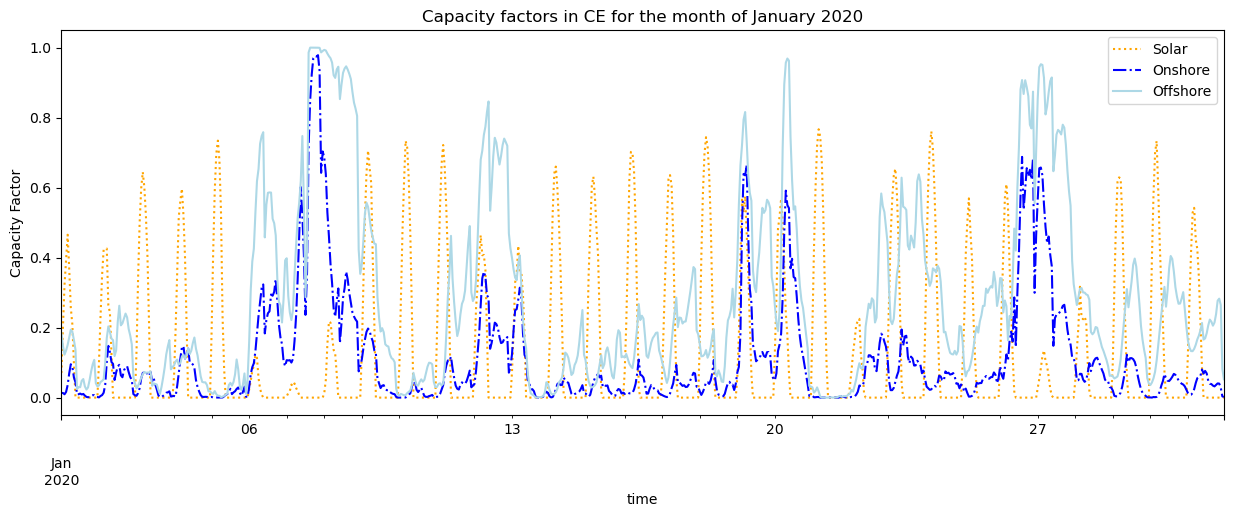

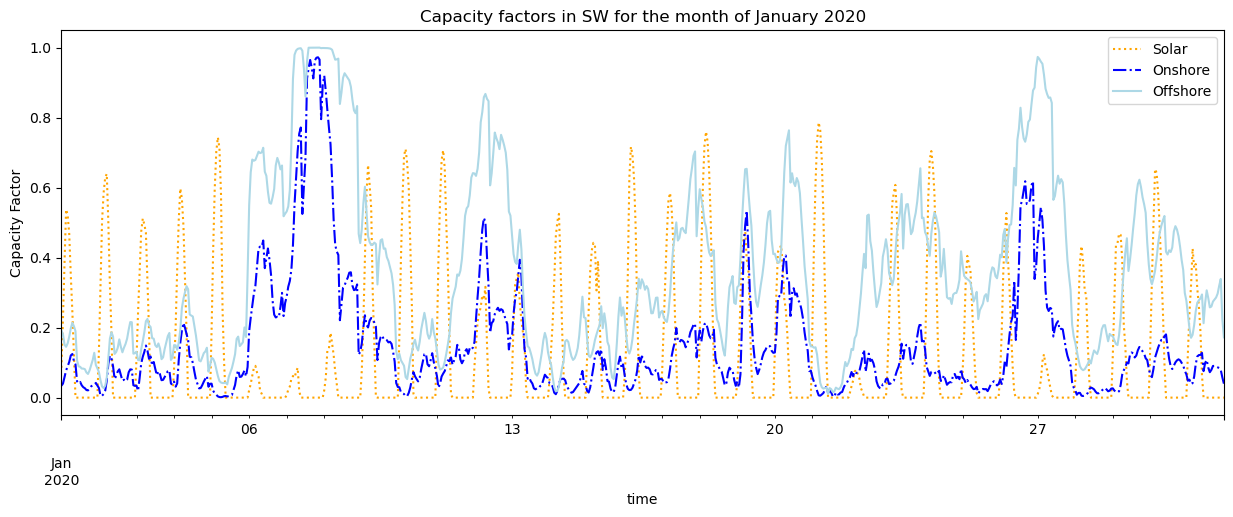

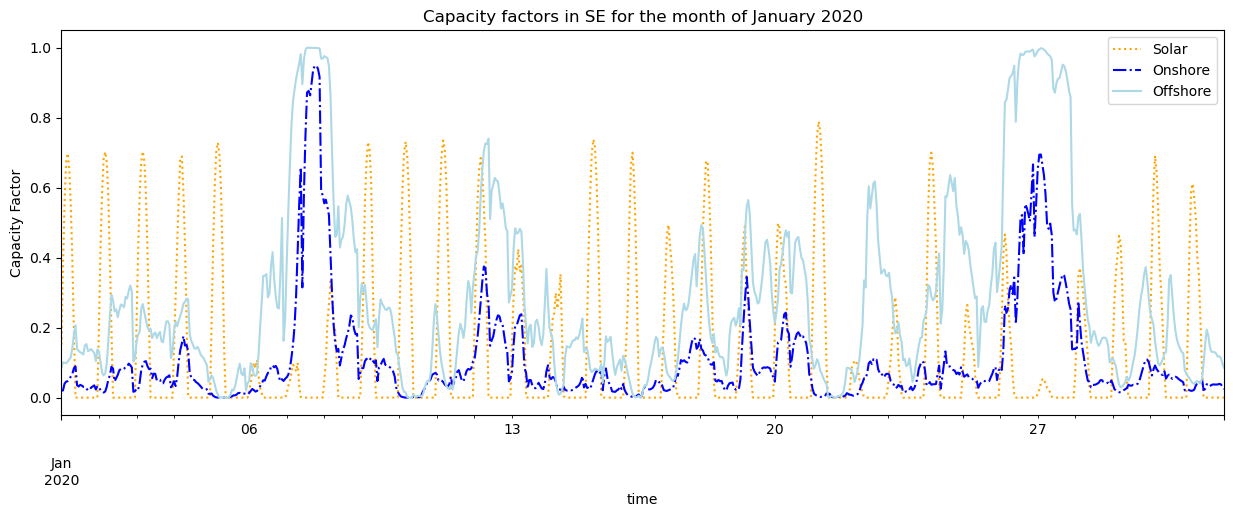

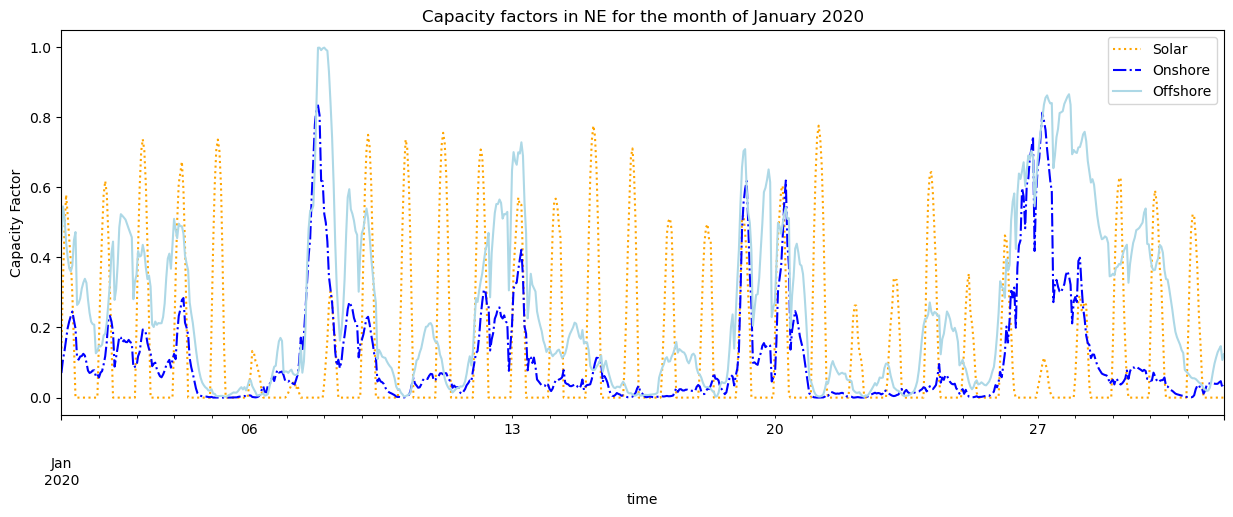

In [39]:
for region in region_names:
    ts = pd.Series(solar_df[region], index=solar_df.index)
    us = pd.Series(onshore_df[region], index=onshore_df.index)
    vs = pd.Series(offshore_df[region], index=offshore_df.index)

    fig, ax = plt.subplots(figsize=(15,5))
    plt.title(f'Capacity factors in {region} for the month of January 2020')
    ts.loc['2020-01'].plot(color="orange", linestyle=':', label='Solar')
    us.loc['2020-01'].plot(color="blue", linestyle='-.', label='Onshore')
    vs.loc['2020-01'].plot(color="lightblue", label='Offshore')
    plt.ylabel('Capacity Factor')
    plt.legend(loc="upper right")

<a id='4'></a>
# 4 Building curent network data <font size=5>[&#x1F815;](#Contents)</font>

<a id='4.1'></a>
## 4.1 Data frames creation for the profiles. <font size=5>[&#x1F815;]()</font>

In [40]:
df_offwind_cap = offshore_areas.copy()
df_onwind_cap = onshore_areas.copy()
df_solar_cap = solar_areas.copy()

In [41]:
df_offwind_cap_factor = offshore_df.copy()
df_onwind_cap_factor = onshore_df.copy()
df_solar_cap_factor = solar_df.copy()

In [42]:
df_offwind_cap_factor = df_offwind_cap_factor.drop(labels = df_offwind_cap_factor.loc['2020-02-29 00:00:00':'2020-02-29 23:00:00'].index.array , axis = 0)
df_onwind_cap_factor = df_onwind_cap_factor.drop(labels = df_onwind_cap_factor.loc['2020-02-29 00:00:00':'2020-02-29 23:00:00'].index.array , axis = 0)
df_solar_cap_factor = df_solar_cap_factor.drop(labels = df_solar_cap_factor.loc['2020-02-29 00:00:00':'2020-02-29 23:00:00'].index.array , axis = 0)
len(df_solar_cap_factor) == len(df_onwind_cap_factor) == len(df_offwind_cap_factor) == 8760

True

In [43]:
points = points.to_crs(4087)
distances = pd.concat({k: points.distance(p) for k, p in points.items()}, axis=1).div(1e3)

dict = {1: 'NW',
        2: 'CE',
        3: 'SW',
        4: 'SE',
        5: 'NE',}
distances.rename(columns=dict, inplace=True)
distances.rename(index=dict, inplace=True)
distances

NW          CE          SW          SE          NE
regions                                                            
NW         0.000000  107.940030  263.880650  288.722996  211.870172
CE       107.940030    0.000000  156.289595  205.416355  212.632182
SW       263.880650  156.289595    0.000000  170.656198  305.907936
SE       288.722996  205.416355  170.656198    0.000000  199.082815
NE       211.870172  212.632182  305.907936  199.082815    0.000000

<a id='4.2'></a>
## 4.2  Power plants and separation by region. <font size=5>[&#x1F815;]()</font>

In [44]:
df = pd.read_csv("global_power_plant_database.csv")
#only korean pp's
df = df[df.country == 'KOR']

#No existing wind and solar pp's to be considered
df = df.drop(df[(df.primary_fuel == "Solar")].index)
df = df.drop(df[(df.primary_fuel == "Wind")].index)

#create geopandas and reset index
df = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
df.reset_index(drop=True, inplace=True)

In [45]:
#finding out the name of the province where the PP is located
df["region"] = pd.Series(dtype='str')
for i in range(len(provinces)):
    for j in range(len(df)):
        if provinces.geometry.iloc[i].contains(df.geometry.iloc[j]):
            df.iloc[j,37] = provinces.index[i]

In [46]:
df[df.region.isna()] # Finding region with NaN value

country country_long                          name   gppd_idnr  \
83     KOR  South Korea  Sihwa Lake Tidal Power Plant  WRI1029923   

    capacity_mw  latitude  longitude    primary_fuel other_fuel1 other_fuel2  \
83        254.0   37.3142   126.6136  Wave and Tidal         NaN         NaN   

    ... estimated_generation_gwh_2015  estimated_generation_gwh_2016  \
83  ...                           NaN                            NaN   

   estimated_generation_gwh_2017 estimated_generation_note_2013  \
83                           NaN                  NO-ESTIMATION   

   estimated_generation_note_2014 estimated_generation_note_2015  \
83                  NO-ESTIMATION                  NO-ESTIMATION   

   estimated_generation_note_2016  estimated_generation_note_2017  \
83                  NO-ESTIMATION                   NO-ESTIMATION   

                      geometry  region  
83  POINT (126.61360 37.31420)     NaN  

[1 rows x 38 columns]

In [47]:
#fixing NaN value
df.loc[83,"region"] = 'NW'
df.head()

country country_long              name   gppd_idnr  capacity_mw  latitude  \
0     KOR  South Korea     Andong Kowaco  WRI1029853         90.0   36.5847   
1     KOR  South Korea     Ansan Project  WRI1029881        834.0   37.2952   
2     KOR  South Korea        Anyang CHP  WRI1029882        493.0   37.3936   
3     KOR  South Korea  Asan Baebang CHP  WRI1029883        113.9   36.9909   
4     KOR  South Korea            Baekje  WRI1029865          2.6   36.3174   

   longitude primary_fuel other_fuel1 other_fuel2  ...  \
0   128.7739        Hydro         NaN         NaN  ...   
1   126.7788          Gas         NaN         NaN  ...   
2   126.9671          Gas         NaN         NaN  ...   
3   126.7135          Gas         NaN         NaN  ...   
4   126.9401        Hydro         NaN         NaN  ...   

  estimated_generation_gwh_2015  estimated_generation_gwh_2016  \
0                         94.46                         148.78   
1                           NaN                            NaN   
2                           NaN                            NaN   
3                           NaN                            NaN   
4                          7.68                           7.34   

  estimated_generation_gwh_2017 estimated_generation_note_2013  \
0                        125.32                       HYDRO-V1   
1                       3457.08                  NO-ESTIMATION   
2                       2043.57                  NO-ESTIMATION   
3                        472.13                  NO-ESTIMATION   
4                          7.24                       HYDRO-V1   

  estimated_generation_note_2014 estimated_generation_note_2015  \
0                       HYDRO-V1                       HYDRO-V1   
1                  NO-ESTIMATION                  NO-ESTIMATION   
2                  NO-ESTIMATION                  NO-ESTIMATION   
3                  NO-ESTIMATION                  NO-ESTIMATION   
4                       HYDRO-V1                       HYDRO-V1   

  estimated_generation_note_2016  estimated_generation_note_2017  \
0                       HYDRO-V1                        HYDRO-V1   
1                  NO-ESTIMATION              CAPACITY-FACTOR-V1   
2                  NO-ESTIMATION              CAPACITY-FACTOR-V1   
3                  NO-ESTIMATION              CAPACITY-FACTOR-V1   
4                       HYDRO-V1                        HYDRO-V1   

                     geometry  region  
0  POINT (128.77390 36.58470)      NE  
1  POINT (126.77880 37.29520)      NW  
2  POINT (126.96710 37.39360)      NW  
3  POINT (126.71350 36.99090)      CE  
4  POINT (126.94010 36.31740)      CE  

[5 rows x 38 columns]

In [48]:
# Grouping Powerplants with respect to primary fuel and capacity
df_fossils = df.groupby(["region","primary_fuel"]).capacity_mw.sum().unstack().fillna(0)
df_fossils = df_fossils.drop(axis = 1 , columns = ["Biomass" , "Waste" , "Wave and Tidal"])
df_fossils

primary_fuel     Coal      Gas    Hydro  Nuclear     Oil
region                                                  
CE            14400.0   4097.9   508.20      0.0     0.0
NE             3959.0   1754.0  2975.86  10699.0     0.0
NW             5080.0  19108.0   533.00      0.0  1400.0
SE             7790.0   1800.0  1410.00   6477.0  3255.0
SW             1904.0   4793.0   636.00   5900.0     0.0

In [49]:
# Hydro plants calculations
hydro_nom = df_fossils.Hydro.sum()
hydro_generation = df.groupby("primary_fuel").estimated_generation_gwh_2017.sum().loc["Hydro"]* 1e3
capacity_factor_hydro = hydro_generation / (hydro_nom * 8760)
df_fossils["Hydro"] = df_fossils["Hydro"] * capacity_factor_hydro
df_fossils

primary_fuel     Coal      Gas       Hydro  Nuclear     Oil
region                                                     
CE            14400.0   4097.9   89.211134      0.0     0.0
NE             3959.0   1754.0  522.392456  10699.0     0.0
NW             5080.0  19108.0   93.564610      0.0  1400.0
SE             7790.0   1800.0  247.516134   6477.0  3255.0
SW             1904.0   4793.0  111.645575   5900.0     0.0

<a id='4.3'></a>
## 4.3 Loading of Population and Load. <font size=5>[&#x1F815;]()</font>

In [50]:
# Importing Demand for Korea
load_ts = pd.read_csv("load.csv",index_col="time")
load_ts = load_ts["KR"]
load_ts = load_ts.to_frame()

#Inserting population for South Korea regions
population_state = {"Busan": 3349016,
                    "Chungcheongbuk-do": 1632088,
                    "Chungcheongnam-do": 2176636,
                    "Daegu": 2410700,
                    "Daejeon": 1488435,
                    "Gangwon-do": 1521763,
                    "Gwangju": 1477573,
                    "Gyeonggi-do": 13511676,
                    "Gyeongsangbuk-do": 2644757,
                    "Gyeongsangnam-do": 3333056,
                    "Incheon": 2945454,
                    "Jeju": 670858,
                    "Jeollabuk-do": 1802766,
                    "Jeollanam-do": 1788807,
                    "Sejong": 353933,
                    "Seoul": 9586195,
                    "Ulsan": 1135423}

#https://www.citypopulation.de/en/southkorea/cities/

population_state = pd.DataFrame.from_dict(population_state,orient="index")
population_state.rename(columns = {0:'total_population'}, inplace = True)
population_state["percentage"] = population_state["total_population"]/population_state.total_population.sum()*100
population_state["regions"] = [4,2,2,5,2,5,3,1,5,4,1,4,3,3,2,1,4]

#population_state = population_state.groupby("regions")
population_region = population_state.groupby("regions").percentage.sum().to_frame()
population_region["total_population"] = population_state.groupby("regions").total_population.sum()
population_region.rename(index=dict, inplace=True)
population_region

percentage  total_population
regions                              
NW        50.248426          26043325
CE        10.903311           5651092
SW         9.780495           5069146
SE        16.377570           8488353
NE        12.690198           6577220

In [51]:
# Finding demand per region based on the population % of each region with respect to total SK population
for i in range(len(population_region)):
    load_ts[population_region.index[i]] = load_ts["KR"].values * population_region.iloc[i,0]/100

load_ts = load_ts.drop(columns='KR')
load_ts.head()

NW            CE           SW            SE  \
time                                                                         
2013-01-01 00:00:00  49645.183316  10772.414746  9663.078060  16180.953881   
2013-01-01 01:00:00  49297.996130  10697.079253  9595.500570  16067.794467   
2013-01-01 02:00:00  49293.349284  10696.070943  9594.596095  16066.279911   
2013-01-01 03:00:00  49229.897648  10682.302692  9582.245690  16045.598993   
2013-01-01 04:00:00  49265.141514  10689.950192  9589.105655  16057.086096   

                               NE  
time                               
2013-01-01 00:00:00  12537.849626  
2013-01-01 01:00:00  12450.167792  
2013-01-01 02:00:00  12448.994235  
2013-01-01 03:00:00  12432.969577  
2013-01-01 04:00:00  12441.870386

In [52]:
load_ts.index = pd.to_datetime(load_ts.index)
df_onwind_cap_factor.index = load_ts.index
df_offwind_cap_factor.index = load_ts.index
df_solar_cap_factor.index = load_ts.index

# Downsampling capacity factor and Load based on resolution
resolution = 11
load_ts = load_ts.resample(f"{resolution}H").first()
df_onwind_cap_factor = df_onwind_cap_factor.resample(f"{resolution}H").first()
df_offwind_cap_factor = df_offwind_cap_factor.resample(f"{resolution}H").first()
df_solar_cap_factor = df_solar_cap_factor.resample(f"{resolution}H").first()

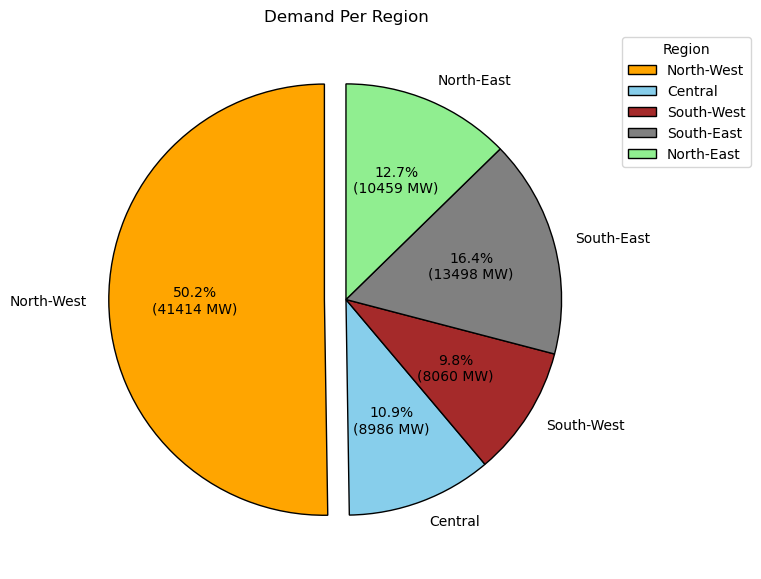

In [53]:
df_loads_mean = load_ts.mean()
df_loads_mean = pd.DataFrame(df_loads_mean, columns = ['Average_Load'])
# df_loads_mean['Average_Load'] = df_loads_mean['Average_Load'] / 1e3

# Creating Demand Pie Chart
explode = (0.1, 0.0, 0.0, 0.0, 0.0)
Regions = ["North-West", "Central","South-West", "South-East", "North-East"]
# Creating color parameters
colors = ( "orange", "skyblue", "brown",
           "grey", "lightgreen")

# Wedge properties
wp = { 'linewidth' : 1, 'edgecolor' : "black" }

# Creating autocpt arguments
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n({:d} MW)".format(pct, absolute)

# Creating plot
fig, ax = plt.subplots(figsize =(10, 7))
wedges, texts, autotexts = ax.pie(df_loads_mean.Average_Load,
                                  autopct = lambda pct: func(pct, df_loads_mean.Average_Load),
                                  explode = explode,
                                  labels = Regions,
                                  colors = colors,
                                  startangle = 90,
                                  wedgeprops = wp
                                  )

# Adding legend
ax.legend(wedges, Regions,
          title ="Region",
          loc ="upper left",
          bbox_to_anchor =(1, 0, 0.5, 1))

plt.setp(autotexts, size = 10)
ax.set_title("Demand Per Region")
# plt.text(-1.5,1, f' Total Demand {round(df_loads_mean.sum().item(),1)} GW')

# show plot
plt.show()

<a id='4.4'></a>
## 4.4 VOM and FOM cost addition. <font size=5>[&#x1F815;]()</font>

In [54]:
# Importing technology costs for 2020
year = 2020
url = f"https://raw.githubusercontent.com/PyPSA/technology-data/master/outputs/costs_{year}.csv"
costs = pd.read_csv(url, index_col=[0,1])

In [55]:
# Creating function for annuity calculation
def annuity(r, n):
    return r / (1.0 - 1.0 / (1.0 + r) ** n)

In [56]:
# Unstacking Costs and assigning default values
costs.loc[costs.unit.str.contains("/kW"), "value"] *= 1e3
costs.unit = costs.unit.str.replace("/kW", "/MW")

defaults = {
    "FOM": 0,
    "VOM": 0,
    "efficiency": 1,
    "fuel": 0,
    "investment": 0,
    "lifetime": 25,
    "CO2 intensity": 0,
    "discount rate": 0.07,
}
costs = costs.value.unstack().fillna(defaults)

#Fixing costs for OCGT/CCGT
costs.at["OCGT", "fuel"] = costs.at["gas", "fuel"]
costs.at["CCGT", "fuel"] = costs.at["gas", "fuel"]
costs.at["OCGT", "CO2 intensity"] = costs.at["gas", "CO2 intensity"]
costs.at["CCGT", "CO2 intensity"] = costs.at["gas", "CO2 intensity"]

In [57]:
annuity = costs.apply(lambda x: annuity(x["discount rate"], x["lifetime"]), axis=1)
costs["marginal_cost"] = costs["VOM"] + costs["fuel"] / costs["efficiency"]
costs["capital_cost"] = (annuity + costs["FOM"] / 100) * costs["investment"]

<a id='5'></a>
## 5 Building the pypsa network. <font size=5>[&#x1F815;]()</font>

In [279]:
n = pypsa.Network()

In [280]:
n.snapshot_weightings.loc[:,:] = resolution

In [281]:
points = provinces.representative_point()
points = points.to_frame()
points["x"] = points.centroid.x
points["y"] = points.centroid.y

<a id='5.1'></a>
## 5.1 Buses creation. <font size=5>[&#x1F815;]()</font>

In [282]:
for i in range(1,6):
    n.add("Bus", f"{region_names[i-1]}",y=points.iloc[i-1,2] , x=points.iloc[i-1,1])

In [283]:
n.set_snapshots(load_ts.index) # Setting Load time series dates as snapshot

<a id='5.2'></a>
## 5.2 Carriers loading. <font size=5>[&#x1F815;]()</font>

In [284]:
carriers = ["offwind","onwind","solar","coal" , "gas" , "hydro" , "nuclear" , "oil","hydrogen storage underground", "battery storage"]

n.madd(
    "Carrier",
    carriers,
    color=["cyan","blue","gold","grey","indianred","green","orange","chocolate","magenta", "yellowgreen"],
    co2_emissions=[costs.at[c, "CO2 intensity"] for c in carriers]
)
n.add(
    "Carrier",
    "HVAC",
    color = "brown",
    co2_emissions = 0
)

<a id='5.3'></a>
## 5.3 Building Generators. <font size=5>[&#x1F815;]()</font>

In [285]:
# Adding existing generators
generators = ["coal" , "gas" , "hydro" , "nuclear" , "oil"]

for i in range(1,6):
    for g in generators:
        n.add(
            "Generator",
            f"{g} {region_names[i-1]}",
            bus= f'{region_names[i-1]}',
            carrier= f"{g}",
            capital_cost=costs.at[g, "capital_cost"],
            marginal_cost=costs.at[g, "marginal_cost"],
            efficiency=costs.at[g, "efficiency"],
            p_nom_extendable=False,
            p_nom = df_fossils.iloc[i-1, generators.index(g)],
        )

In [286]:
# Adding renewable energy generators
myVars = globals()
for carr in ["solar","offwind","onwind"]:
    for i in range(1,6):
        n.add(
            "Generator",
            f"{carr} {region_names[i-1]}",
            bus=f'{region_names[i-1]}',
            carrier=f"{carr}",
            p_max_pu=myVars[f"df_{carr}_cap_factor"][region_names[i-1]].values,
            capital_cost=costs.at[f"{carr}", "capital_cost"],
            marginal_cost=costs.at[f"{carr}", "marginal_cost"],
            efficiency=costs.at[f"{carr}", "efficiency"],
            p_nom_extendable=True,
            p_nom_max = myVars[f"df_{carr}_cap"].at[ region_names[i-1] , "Cap per region"] * 6
        )

In [287]:
for i in range(1,6):
    n.add(
        "Load",
        f"Demand {region_names[i-1]}",
        bus=f"{region_names[i-1]}",
        p_set=load_ts.iloc[:,i-1],
    )

<a id='5.4'></a>
## 5.4 Links and Storages. <font size=5>[&#x1F815;]()</font>

In [288]:
#Adding Battery storage
for i in range(1,6):
    n.add(
        "StorageUnit",
        f"battery storage {region_names[i-1]}",
        bus=f'{region_names[i-1]}',
        carrier="battery storage",
        max_hours=6,
        capital_cost=costs.at["battery inverter", "capital_cost"] + 6 * costs.at["battery storage", "capital_cost"],
        efficiency_store=costs.at["battery inverter", "efficiency"],
        efficiency_dispatch=costs.at["battery inverter", "efficiency"],
        p_nom_extendable=True,
        cyclic_state_of_charge=True,
    )

In [289]:
#Adding Hydrogen storage
capital_costs = (
        costs.at["electrolysis", "capital_cost"] +
        costs.at["fuel cell", "capital_cost"] +
        504 * costs.at["hydrogen storage underground", "capital_cost"]
)

for i in range(1,6):
    n.add(
        "StorageUnit",
        f"hydrogen storage underground {region_names[i-1]}",
        bus=f'{region_names[i-1]}',
        carrier="hydrogen storage underground",
        max_hours=504,
        capital_cost=capital_costs,
        efficiency_store=costs.at["electrolysis", "efficiency"],
        efficiency_dispatch=costs.at["fuel cell", "efficiency"],
        p_nom_extendable=True,
        cyclic_state_of_charge=True,
    )

In [290]:
# Adding Links for buses next to each other
for i in range(1,5):
    n.add(
        "Link",
        f"{region_names[i-1]}-{region_names[i]}",
        bus0 = f"{region_names[i-1]}",
        bus1 = f"{region_names[i]}",
        efficiency = 1,
        marginal_cost = 0,
        p_min_pu = -1,
        length = distances[region_names[i-1]][region_names[i]] * 1.5,
        capital_cost = 400 * distances[region_names[i-1]][region_names[i]] *1.5,
        p_nom_extendable = True,
        carrier = "HVAC",
    )

In [291]:
#Adding 3 additional links

In [292]:
n.add(
    "Link",
    name = "NW-NE",
    bus0 = "NW",
    bus1 = "NE",
    efficiency = 1,
    marginal_cost = 0,
    p_min_pu = -1,
    length = distances.iloc[0,4]*1.5,
    capital_cost = 400 * distances.iloc[0,4]*1.5,
    p_nom_extendable = True,
    carrier = "HVAC",
)

In [293]:
n.add(
    "Link",
    name = "CE-NE",
    bus0 = "CE",
    bus1 = "NE",
    efficiency = 1,
    marginal_cost = 0,
    p_min_pu = -1,
    length = distances.iloc[1,4]*1.5,
    capital_cost = 400 * distances.iloc[1,4]*1.5,
    p_nom_extendable = True,
    carrier = "HVAC",
)

In [294]:
n.add(
    "Link",
    name = "SW-NE",
    bus0 = "SW",
    bus1 = "NE",
    efficiency = 1,
    marginal_cost = 0,
    p_min_pu = -1,
    length = distances.iloc[2,4]*1.5,
    capital_cost = 400 * distances.iloc[2,4]*1.5,
    p_nom_extendable = True,
    carrier = "HVAC",
)

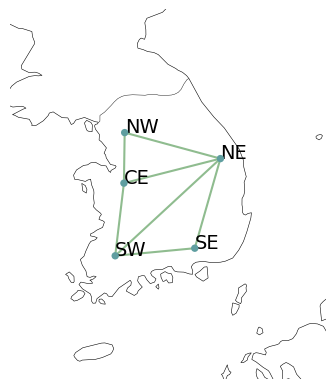

In [295]:
n.plot(margin=1, bus_sizes=0.005)
for i, txt in enumerate(region_names):
    plt.annotate(txt, (points.x[i], points.y[i]))

<a id='6'></a>
## 6 Optimization of the network. <font size=5>[&#x1F815;]()</font>

<a id='6.1'></a>
## 6.1 Current Situation. <font size=5>[&#x1F815;]()</font>

In [296]:
n.lopf(solver_name='gurobi')

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.52s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\juliu\AppData\Local\Temp\pypsa-problem-mvcyk72t.lp
Reading time = 0.23 seconds
obj: 134693 rows, 61402 columns, 258589 nonzeros
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: AMD Ryzen 7 5800U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 134693 rows, 61402 columns and 258589 nonzeros
Model fingerprint: 0xb7bf0b54
Coefficient statistics:
  Matrix range     [1e-06, 5e+02]
  Objective range  [1e-02, 4e+05]
  Bounds range     [9e+02, 9e+04]
  RHS range        [9e+01, 5e+04]
Presolve removed 77745 rows and 6016 columns
Presolve time: 0.10s
Presolved: 56948 rows, 55386 columns, 174829 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.01s

Barrier statistics:
 Dense cols : 32
 Free vars  : 5579
 AA' NZ     : 1.522e+05
 Factor NZ  : 8.387e+05 (roughly 5

INFO:pypsa.linopf:Optimization successful. Objective value: 6.96e+09


('ok', 'optimal')

In [297]:
def plot_dispatch(n, time, ymin, ymax):

    p_by_carrier = n.generators_t.p.groupby(n.generators.carrier, axis=1).sum().div(1e3)

    if not n.storage_units.empty:
        sto = n.storage_units_t.p.groupby(n.storage_units.carrier, axis=1).sum().div(1e3)
        p_by_carrier = pd.concat([p_by_carrier, sto], axis=1)

    fig, ax = plt.subplots(figsize=(25, 15))

    color = p_by_carrier.columns.map(n.carriers.color)

    p_by_carrier.where(p_by_carrier>0).loc[time].plot.area(
        ax=ax,
        linewidth=0,
        color=color,
    )
    plt.rcParams.update({'font.size': 14})

    charge = p_by_carrier.where(p_by_carrier<0).dropna(how='all', axis=1).loc[time]

    if not charge.empty:

        charge.plot.area(
            ax=ax,
            linewidth=0,
            color=charge.columns.map(n.carriers.color),
        )

    n.loads_t.p_set.sum(axis=1).loc[time].div(1e3).plot(ax=ax, c='k')
    
    plt.legend(loc=(1.01,0))
    ax.set_ylabel("GW")
    
    #set axis limit to min and max overall
    ax.set_ylim(ymin, ymax)
    # ax.set_ylim(p_by_carrier.where(p_by_carrier>0).loc[time].min(), p_by_carrier.where(p_by_carrier>0).loc[time].min().max())

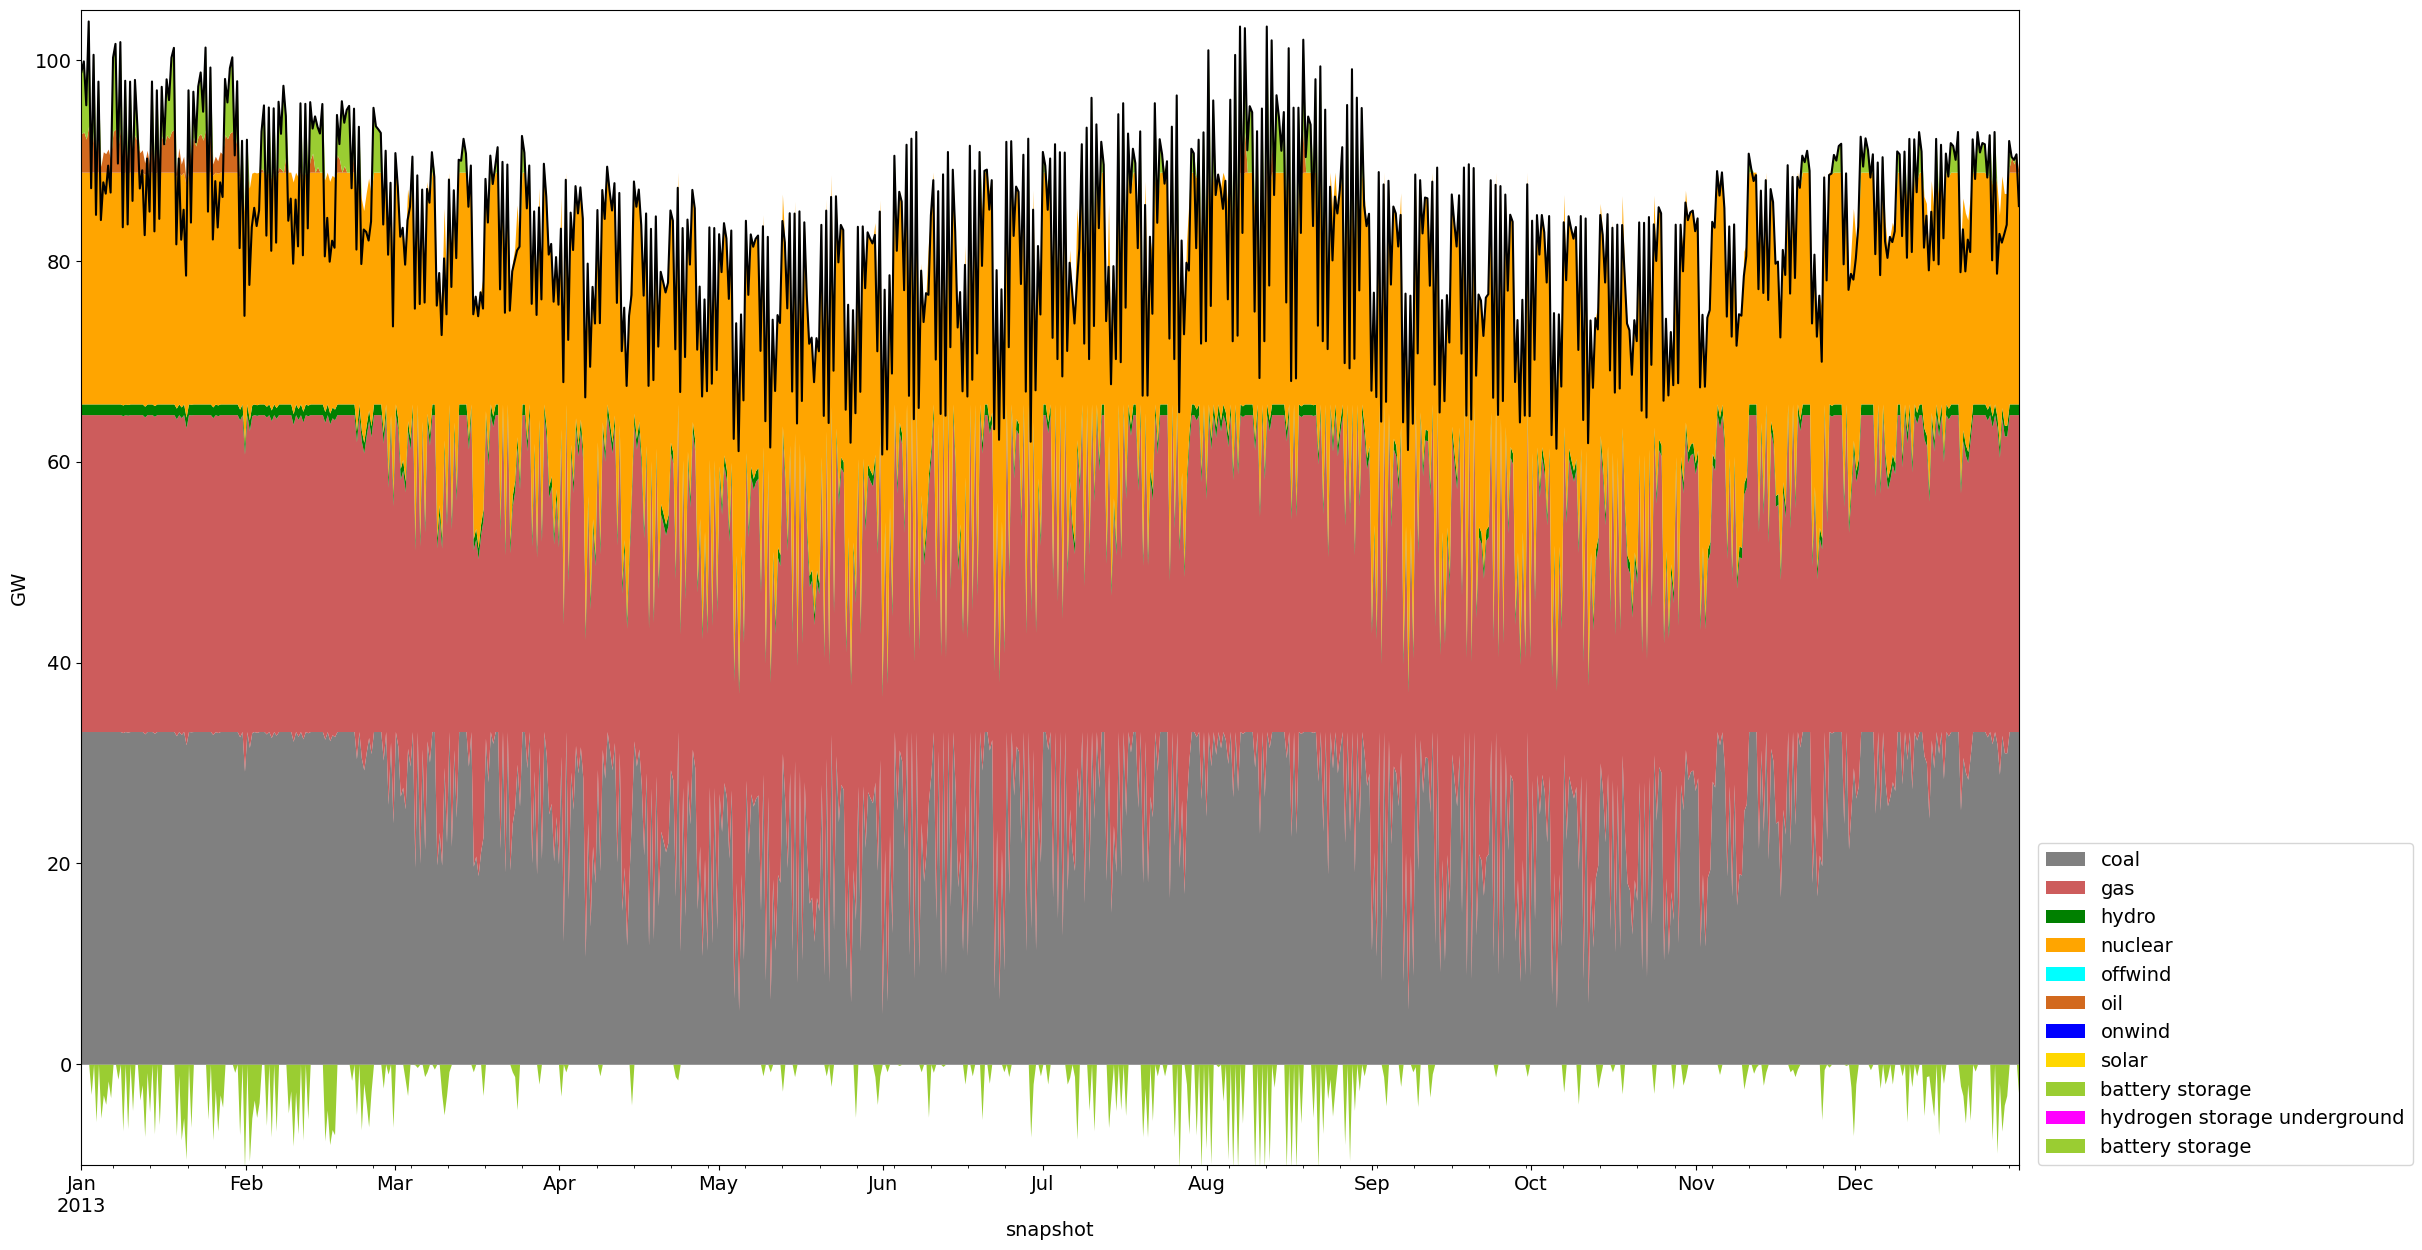

In [298]:
plot_dispatch(n, "2013", -10, 105)

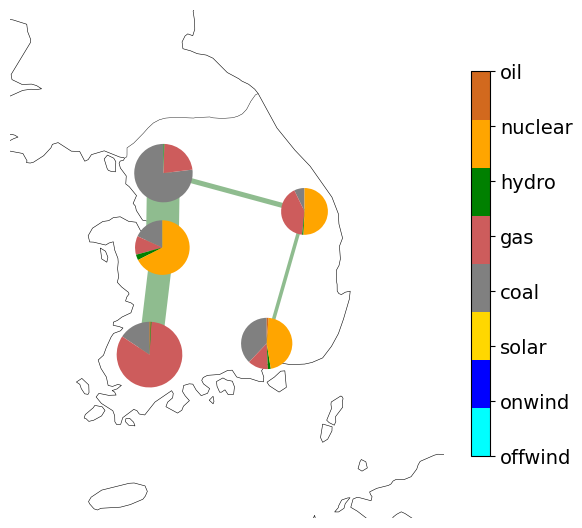

In [299]:
fig = plt.figure(figsize=(7,10))
ax = plt.axes(projection=ccrs.epsg(4087))
capacities = n.generators_t.p.groupby([n.generators.bus, n.generators.carrier], axis = 1).sum().sum()
colorforcarriers = ["cyan","blue","gold","grey","indianred","green","orange","chocolate"]
carrierforcolors = ["offwind","onwind","solar","coal" , "gas" , "hydro" , "nuclear" , "oil"]
norm = plt.Normalize(vmin=n.links_t.p0.iloc[0].abs().min(), vmax=n.links_t.p0.iloc[0].abs().max())

n.plot(
    ax=ax,
    margin=0.9,
    bus_sizes=capacities / 5e7*0.5,
    link_norm=norm,
    link_cmap='jet',
    link_widths= n.links_t.p0.iloc[0].abs() / 1e3
)

norm = mpl.colors.Normalize(vmin=1, vmax=8)

cmap = ListedColormap(colorforcarriers)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar = plt.colorbar(sm, ax=ax, shrink=0.5)
cbar.ax.set_yticklabels(carrierforcolors)

plt.rcParams.update({'font.size': 8})

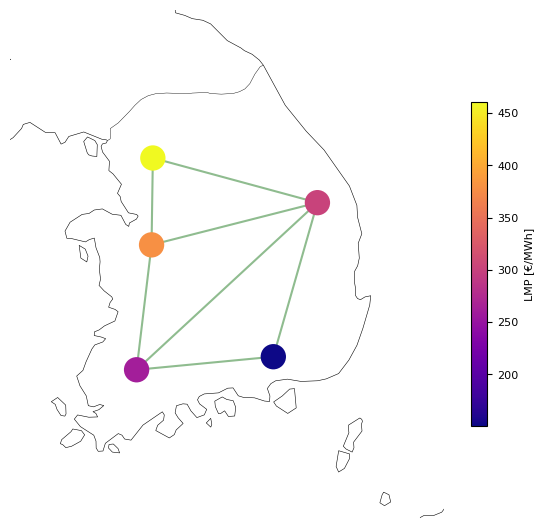

In [300]:
fig = plt.figure(figsize=(7,7))
ax = plt.axes(projection=ccrs.epsg(4087))

norm = plt.Normalize(vmin=n.buses_t.marginal_price.mean().min(), vmax=n.buses_t.marginal_price.mean().max()) # €/MWh

n.plot(
    margin=0.7,
    ax=ax,
    bus_colors=n.buses_t.marginal_price.mean(),
    bus_cmap='plasma',
    bus_norm=norm,
);

sm = plt.cm.ScalarMappable(cmap='plasma', norm=norm)
sm.set_array([])

cbar = plt.colorbar(sm, ax=ax, label="LMP [€/MWh]", shrink=0.6)


In [301]:
n.buses_t.marginal_price.mean()

Bus
NW    460.442162
CE    379.182416
SW    261.524000
SE    151.067266
NE    300.941406
dtype: float64

(0.0, 2000.0)

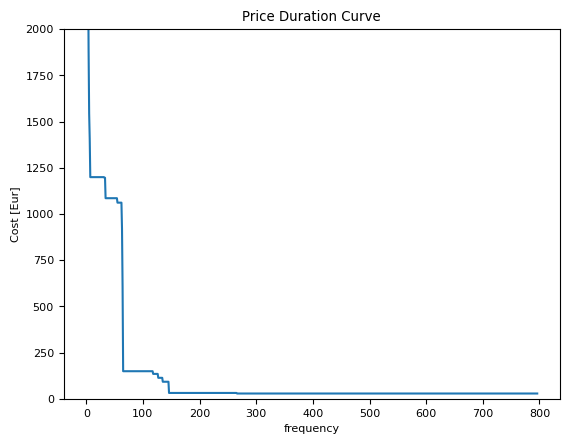

In [302]:
price_duration=n.buses_t.marginal_price
price_duration=price_duration.mean(axis=1)
price_duration=price_duration.sort_values(ascending=False).reset_index(drop=True)
price_duration.plot(ylabel='Cost [Eur]', xlabel='frequency', title='Price Duration Curve')
plt.ylim(0,2000)

Text(0.5, 0, '2013')

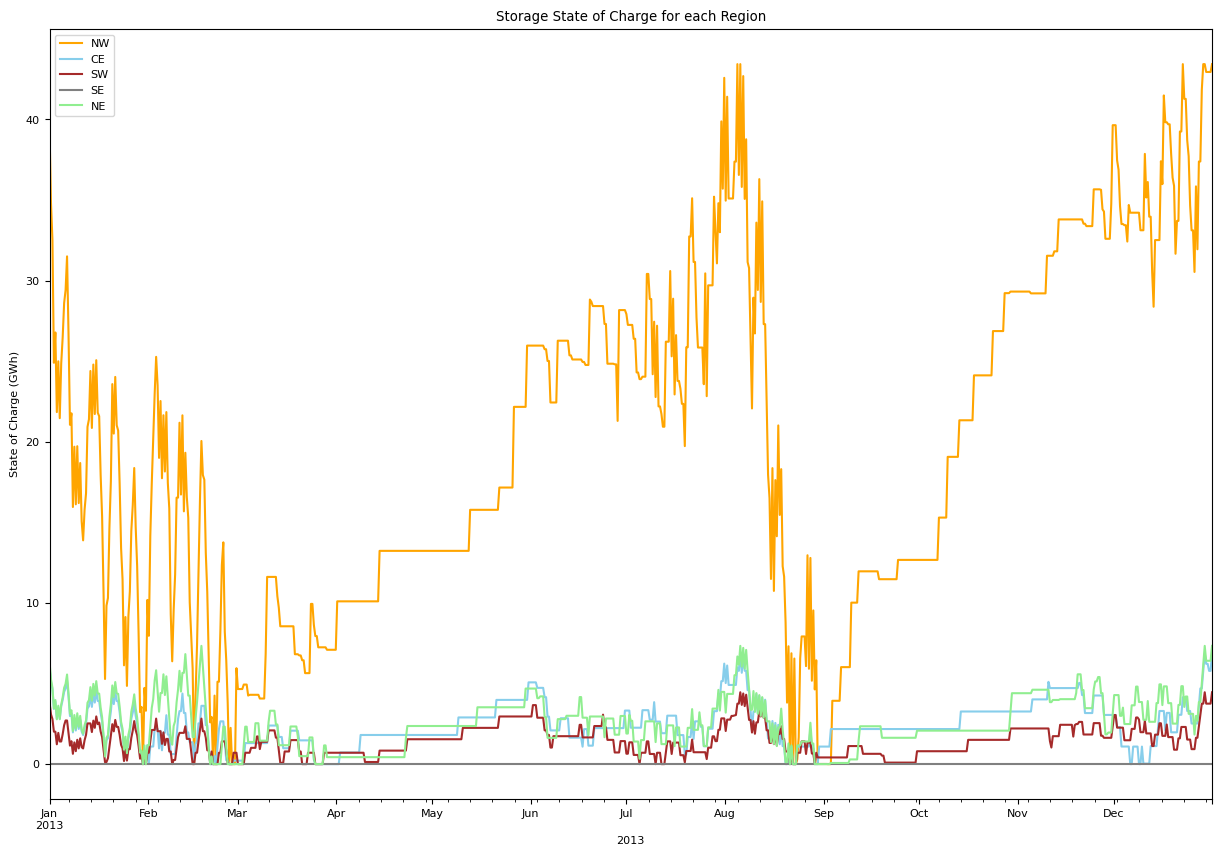

In [303]:
regioncolors = ["orange", "skyblue", "brown","grey", "lightgreen"]
i = 0
test = n.storage_units_t.state_of_charge.groupby([n.storage_units.bus], axis=1).sum()

fig, ax = plt.subplots(figsize=(15,10))

for region in region_names:
    x = test[region] / 1e3
    x.plot(color = regioncolors[i], label=region)
    i += 1

# plt.ylim(, 5)
plt.title('Storage State of Charge for each Region')
plt.legend(loc='upper left')
plt.ylabel('State of Charge (GWh)')
plt.xlabel('2013')

In [304]:
def system_cost(n):
    tsc = n.statistics.capex() + n.statistics.opex()
    return tsc.droplevel(0).div(1e6) # million €/a

In [305]:
demand = n.snapshot_weightings.generators @ n.loads_t.p_set.sum(axis=1)
n_costperMW = system_cost(n).sum()*1e6 / demand.sum()
print(f'Total system cost is € {round(system_cost(n).sum()/ 1e3, 2)} Billion @ {round(n_costperMW,1)} €/MWh')

Total system cost is € 33.89 Billion @ 516.0 €/MWh


<a id='6.2'></a>
## 6.2 Zero CO2 Emission. <font size=5>[&#x1F815;]()</font>

In [306]:
n1 = n.copy()

In [307]:
n1.add(
    "GlobalConstraint",
    "CO2Limit",
    carrier_attribute="co2_emissions",
    sense="<=",
    constant=0,
)

In [308]:
for i in range(1,6):
    n1.remove("Generator",f"gas {dict[i]}")
    n1.remove("Generator",f"coal {dict[i]}")
    n1.remove("Generator",f"oil {dict[i]}")

In [309]:
n1.lopf(solver_name='gurobi')

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.43s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\juliu\AppData\Local\Temp\pypsa-problem-mu1bmsfc.lp
Reading time = 0.19 seconds
obj: 110784 rows, 49447 columns, 222724 nonzeros
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: AMD Ryzen 7 5800U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 110784 rows, 49447 columns and 222724 nonzeros
Model fingerprint: 0x297b8015
Coefficient statistics:
  Matrix range     [1e-06, 5e+02]
  Objective range  [1e-02, 4e+05]
  Bounds range     [9e+02, 9e+04]
  RHS range        [9e+01, 5e+04]
Presolve removed 53845 rows and 3634 columns
Presolve time: 0.11s
Presolved: 56939 rows, 45813 columns, 165355 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 32
 Free vars  : 5570
 AA' NZ     : 1.523e+05
 Factor NZ  : 8.383e+05 (roughly 5

INFO:pypsa.linopf:Optimization successful. Objective value: 5.41e+10


('ok', 'optimal')

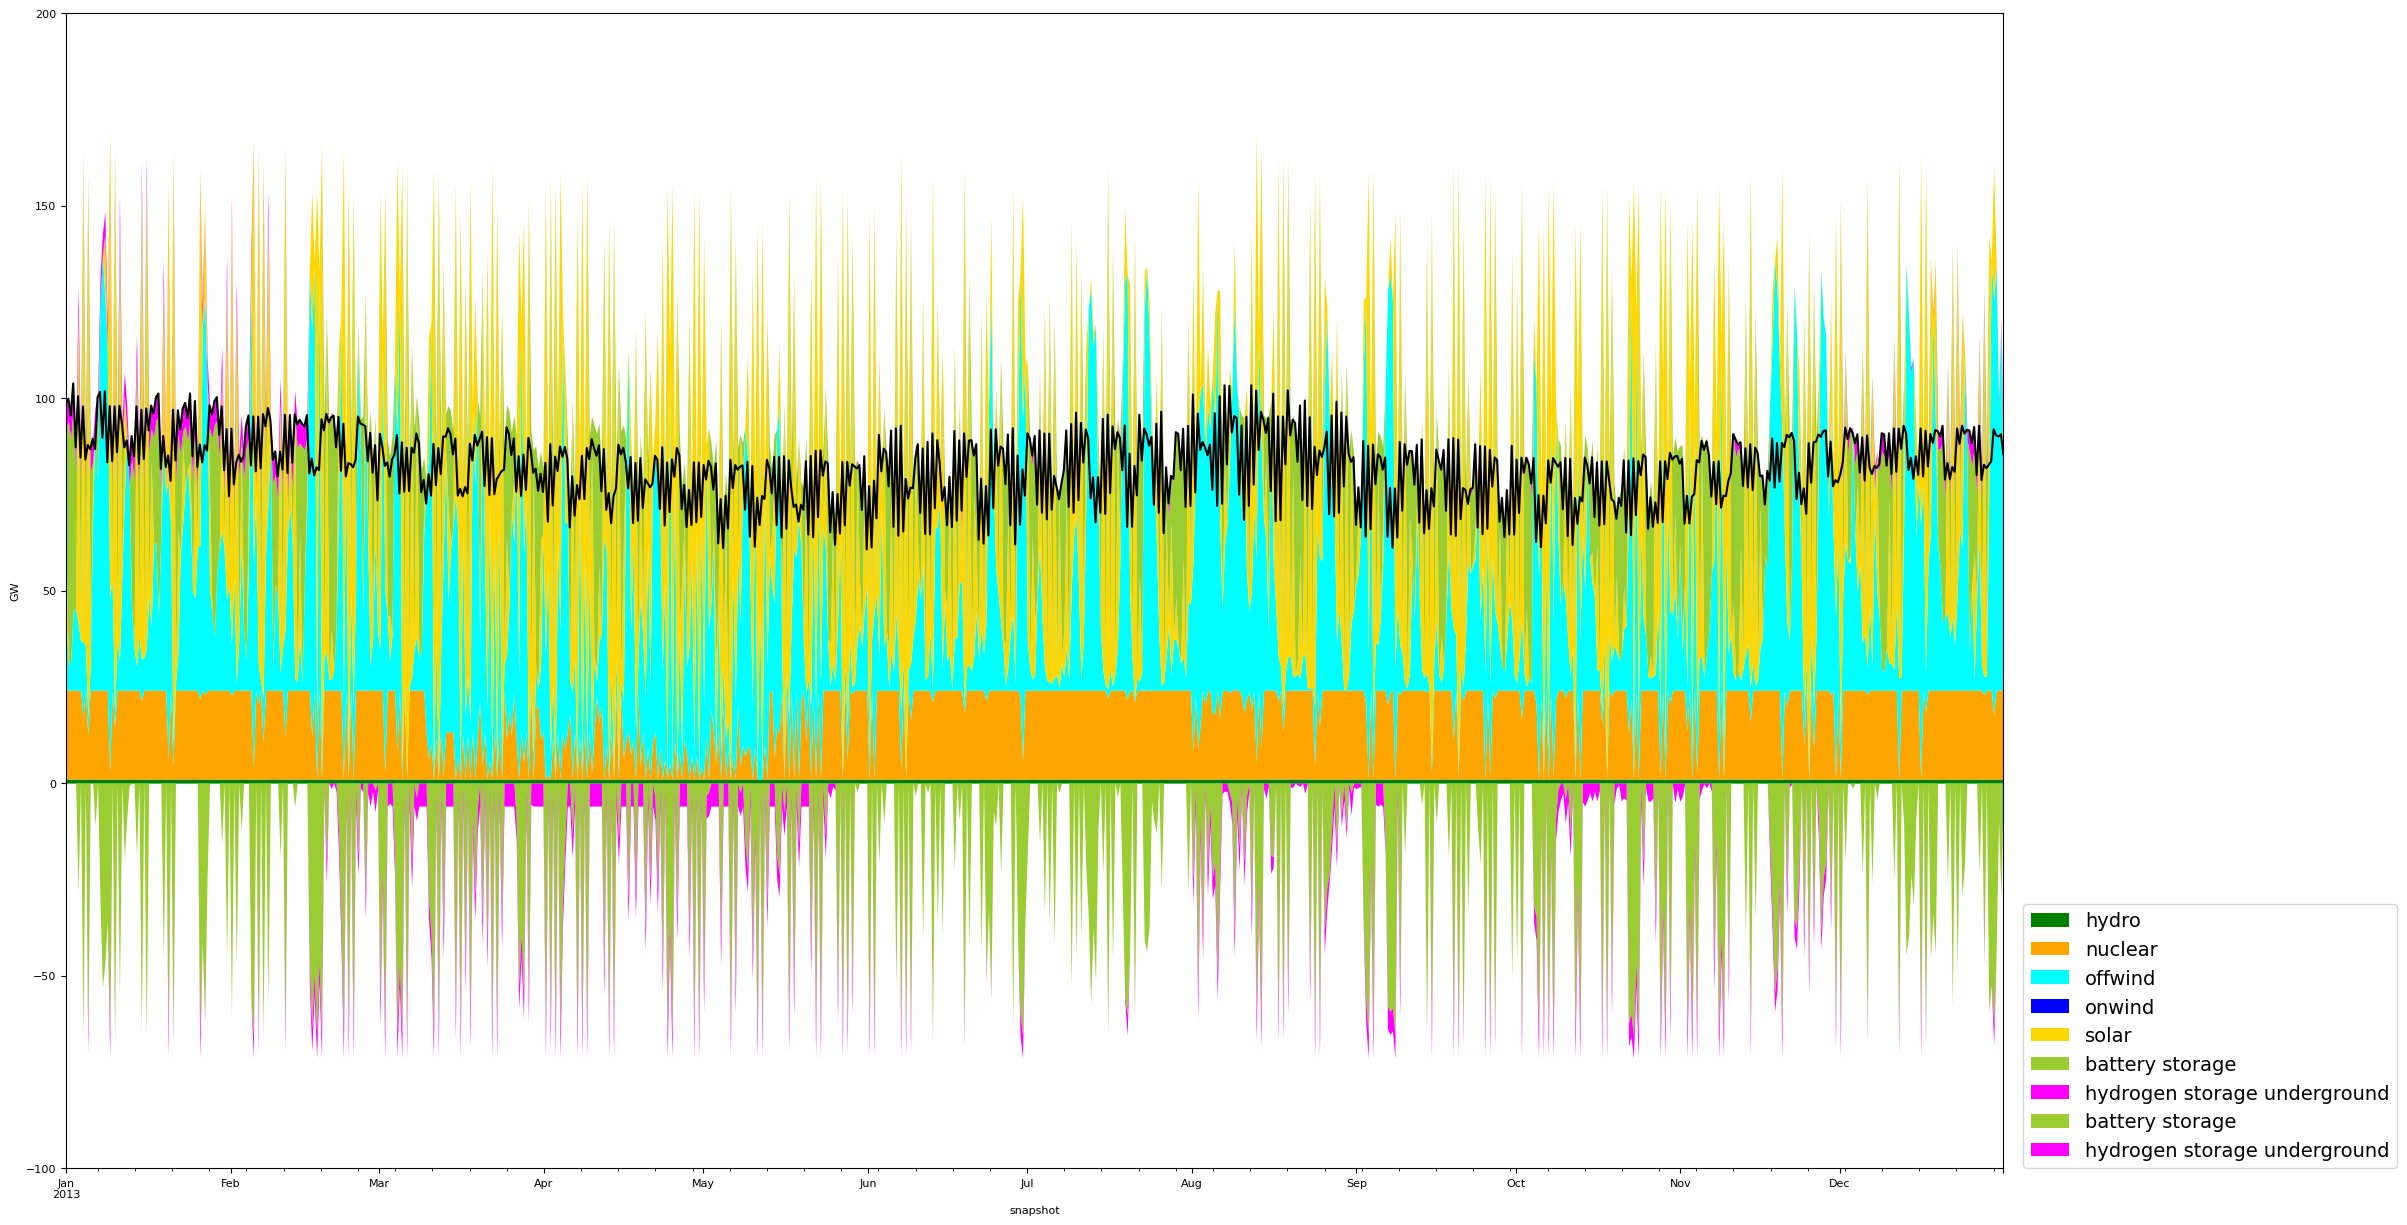

In [310]:
#takes network, time, ymin value and ymax value as arguments
plot_dispatch(n1, "2013", -100, 200)

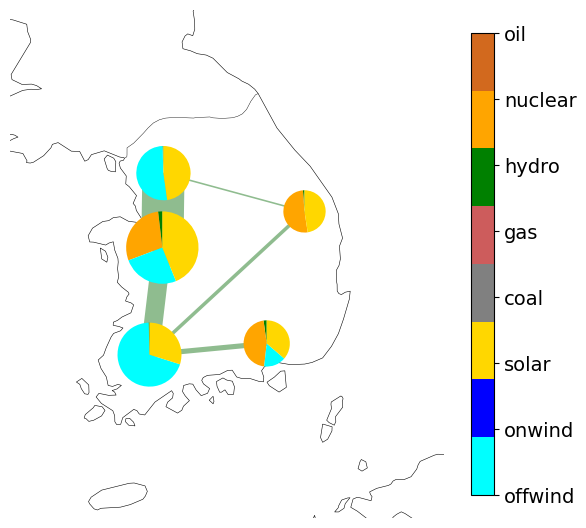

In [311]:
capacities = n1.generators_t.p.groupby([n1.generators.bus, n1.generators.carrier], axis = 1).sum().sum()
carriers = n1.generators.carrier.unique()
colorforcarriers = ["cyan","blue","gold","grey","indianred","green","orange","chocolate"]
carrierforcolors = ["offwind","onwind","solar","coal" , "gas" , "hydro" , "nuclear" , "oil"]

fig = plt.figure(figsize=(7,10))
ax = plt.axes(projection=ccrs.epsg(4087))

norm = plt.Normalize(vmin=n1.links_t.p0.iloc[0].abs().min(), vmax=n1.links_t.p0.iloc[0].abs().max())

n1.plot(
    ax=ax,
    margin=0.9,
    bus_sizes=capacities / 5e7*0.5,
    link_norm=norm,
    link_cmap='jet',
    link_widths= n1.links_t.p0.iloc[0].abs() / 1e3
)

norm = mpl.colors.Normalize(vmin=1, vmax=8)

cmap = ListedColormap(colorforcarriers)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar = plt.colorbar(sm, ax=ax, shrink=0.6)
cbar.ax.set_yticklabels(carrierforcolors)

plt.rcParams.update({'font.size': 10})

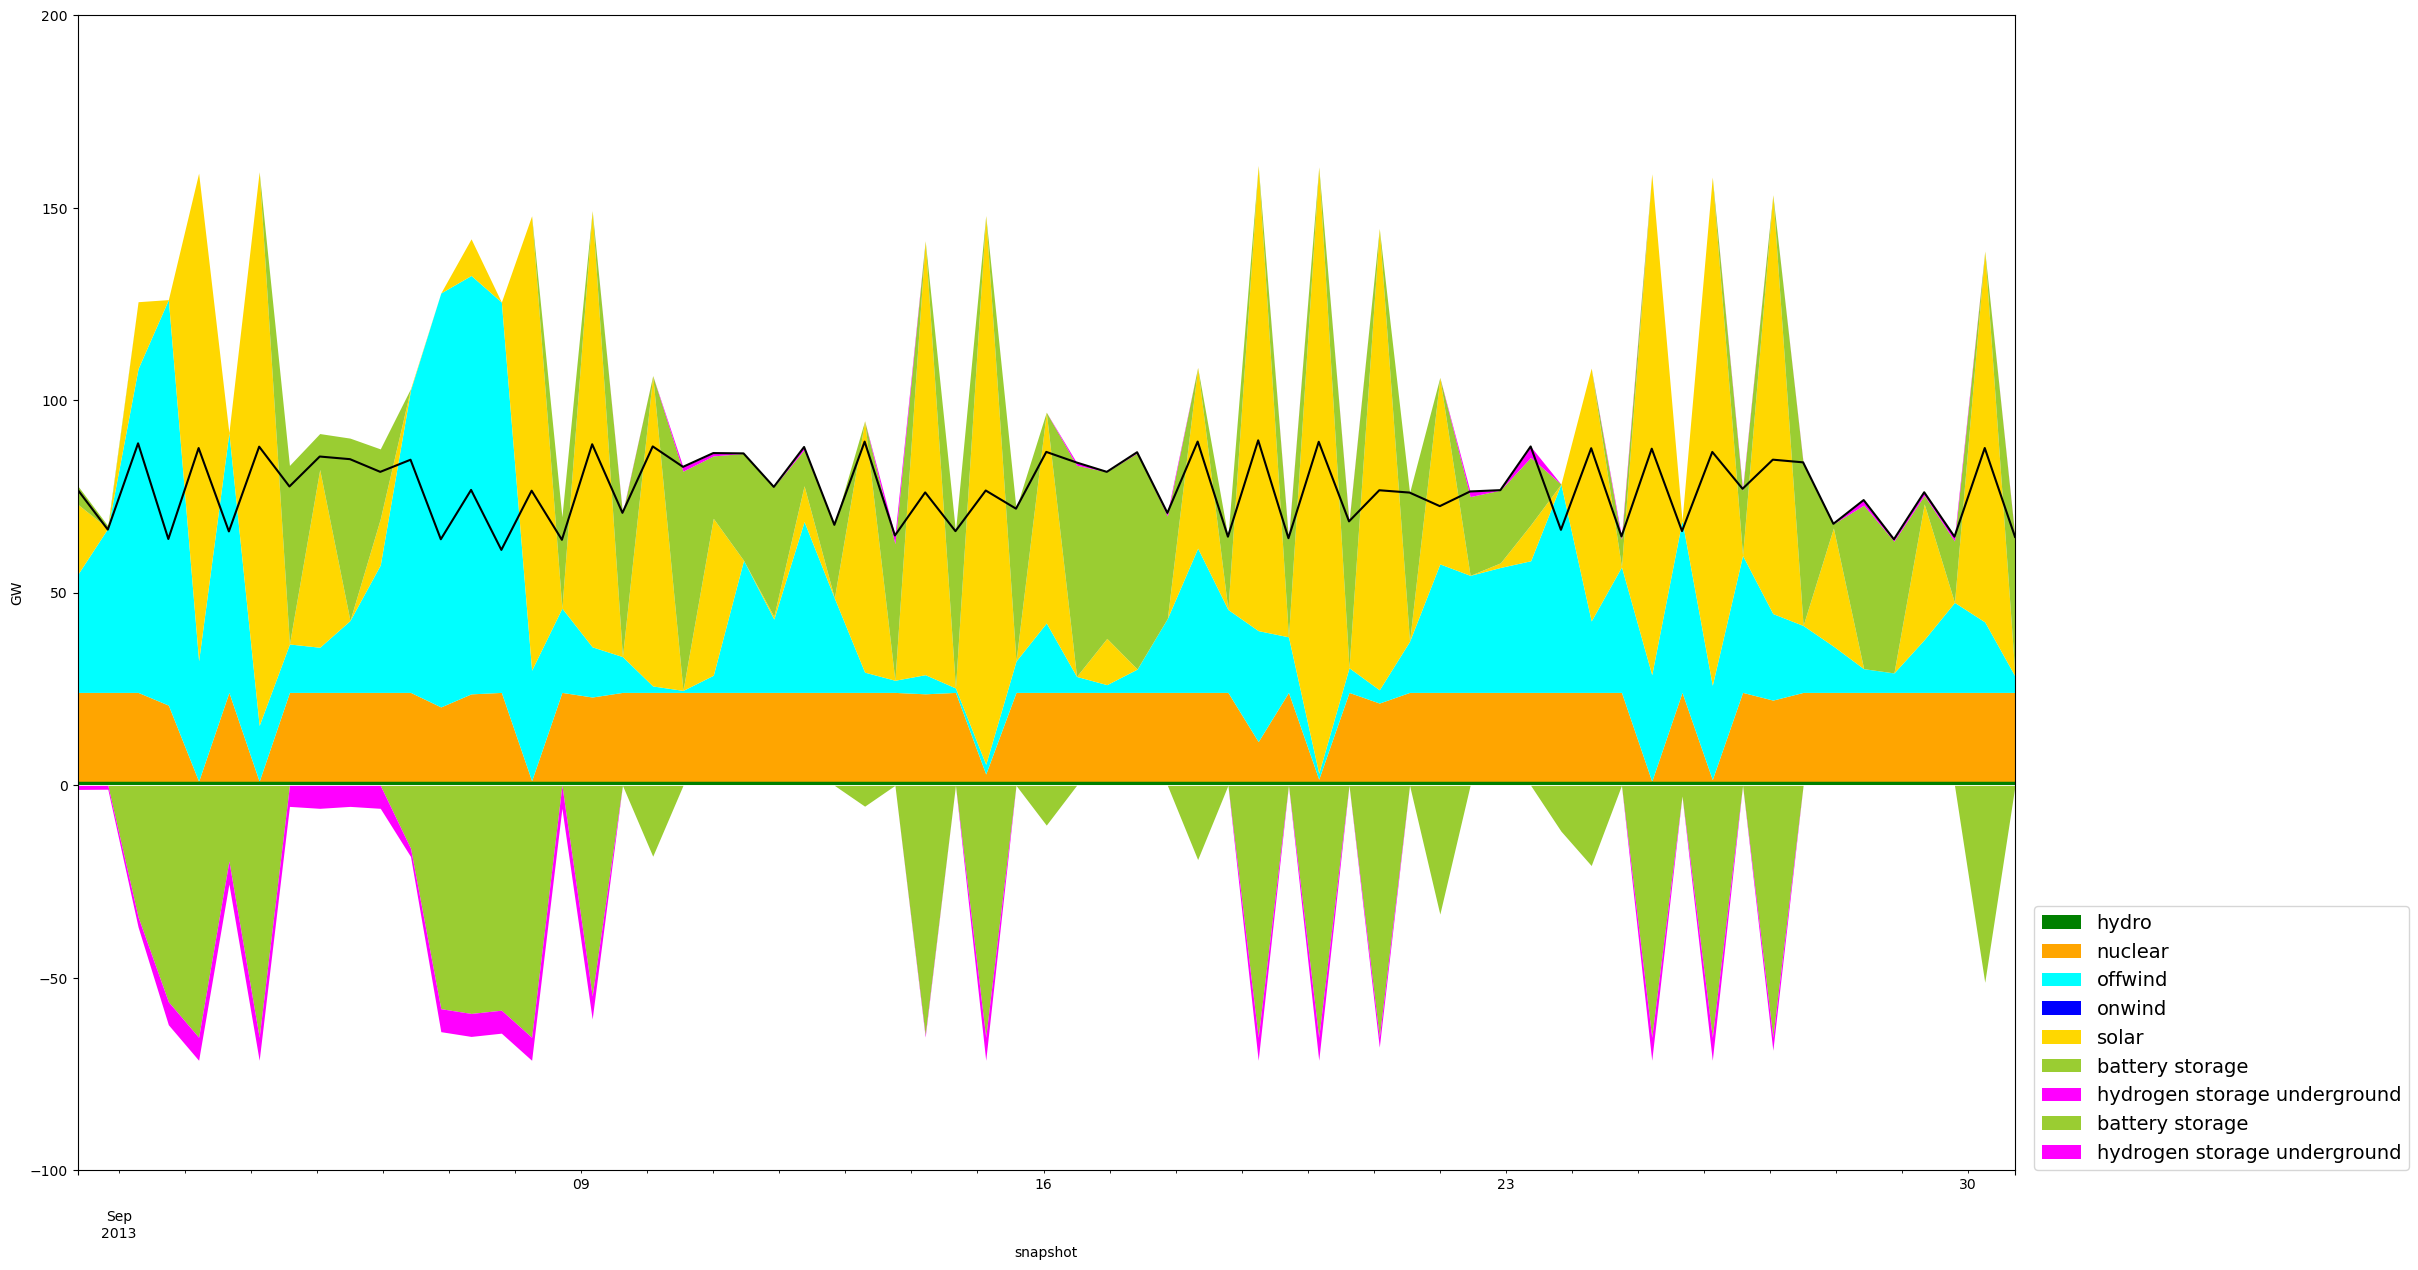

In [312]:
plot_dispatch(n1, "2013-09", -100, 200)

<AxesSubplot: xlabel='snapshot', ylabel='Regional Price[€/MWh]'>

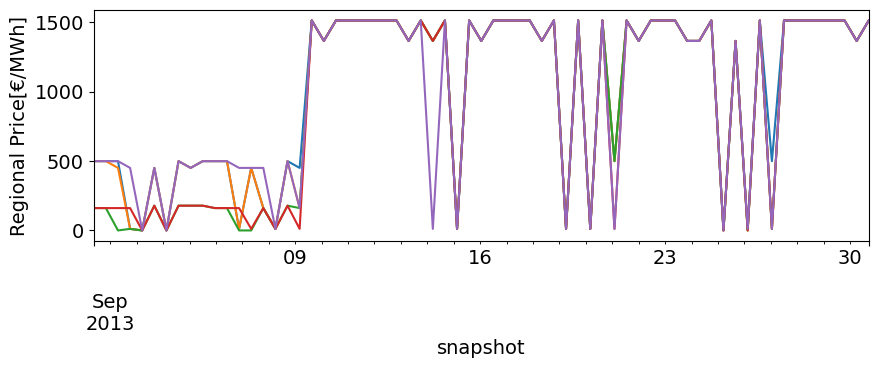

In [313]:
n1.buses_t.marginal_price.loc["2013-09"].plot(figsize=(10,3), ylabel="Regional Price[€/MWh]", legend=False)

<AxesSubplot: title={'center': 'Price Duration\xa0Curve'}, xlabel='frequency', ylabel='Cost [Eur]'>

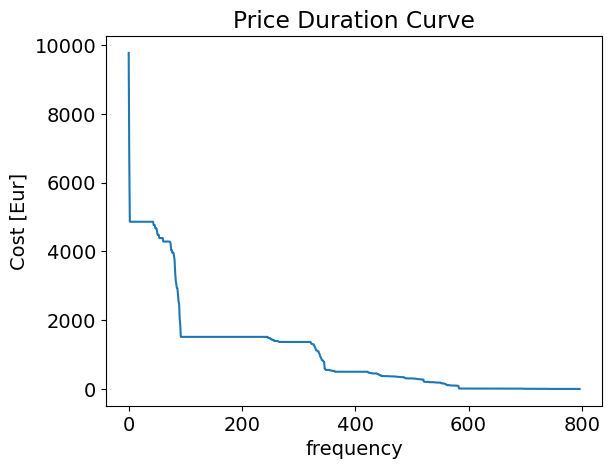

In [314]:
price_duration=n1.buses_t.marginal_price
price_duration=price_duration.mean(axis=1)
price_duration=price_duration.sort_values(ascending=False).reset_index(drop=True)
price_duration.plot(ylabel='Cost [Eur]', xlabel='frequency', title='Price Duration Curve')

In [315]:
n1.buses_t.marginal_price.mean()

Bus
NW    1162.381676
CE    1081.121929
SW     963.463514
SE    1057.595747
NE    1139.906145
dtype: float64

<a id='6.3'></a>
## 6.3 Renewable Energies only. <font size=5>[&#x1F815;]()</font>

In [316]:
n2 = n1.copy()

In [317]:
for i in range(1,6):
    n2.remove("Generator",f"nuclear {dict[i]}")

In [318]:
n2.lopf(solver_name='gurobi')

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.44s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\juliu\AppData\Local\Temp\pypsa-problem-psoqi5n7.lp
Reading time = 0.19 seconds
obj: 102814 rows, 45462 columns, 210769 nonzeros
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: AMD Ryzen 7 5800U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 102814 rows, 45462 columns and 210769 nonzeros
Model fingerprint: 0xac0e0e28
Coefficient statistics:
  Matrix range     [1e-06, 5e+02]
  Objective range  [1e-02, 4e+05]
  Bounds range     [9e+02, 9e+04]
  RHS range        [9e+01, 5e+04]
Presolve removed 45875 rows and 2040 columns
Presolve time: 0.09s
Presolved: 56939 rows, 43422 columns, 162964 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 32
 Free vars  : 5570
 AA' NZ     : 1.523e+05
 Factor NZ  : 8.383e+05 (roughly 5

INFO:pypsa.linopf:Optimization successful. Objective value: 7.43e+10


('ok', 'optimal')

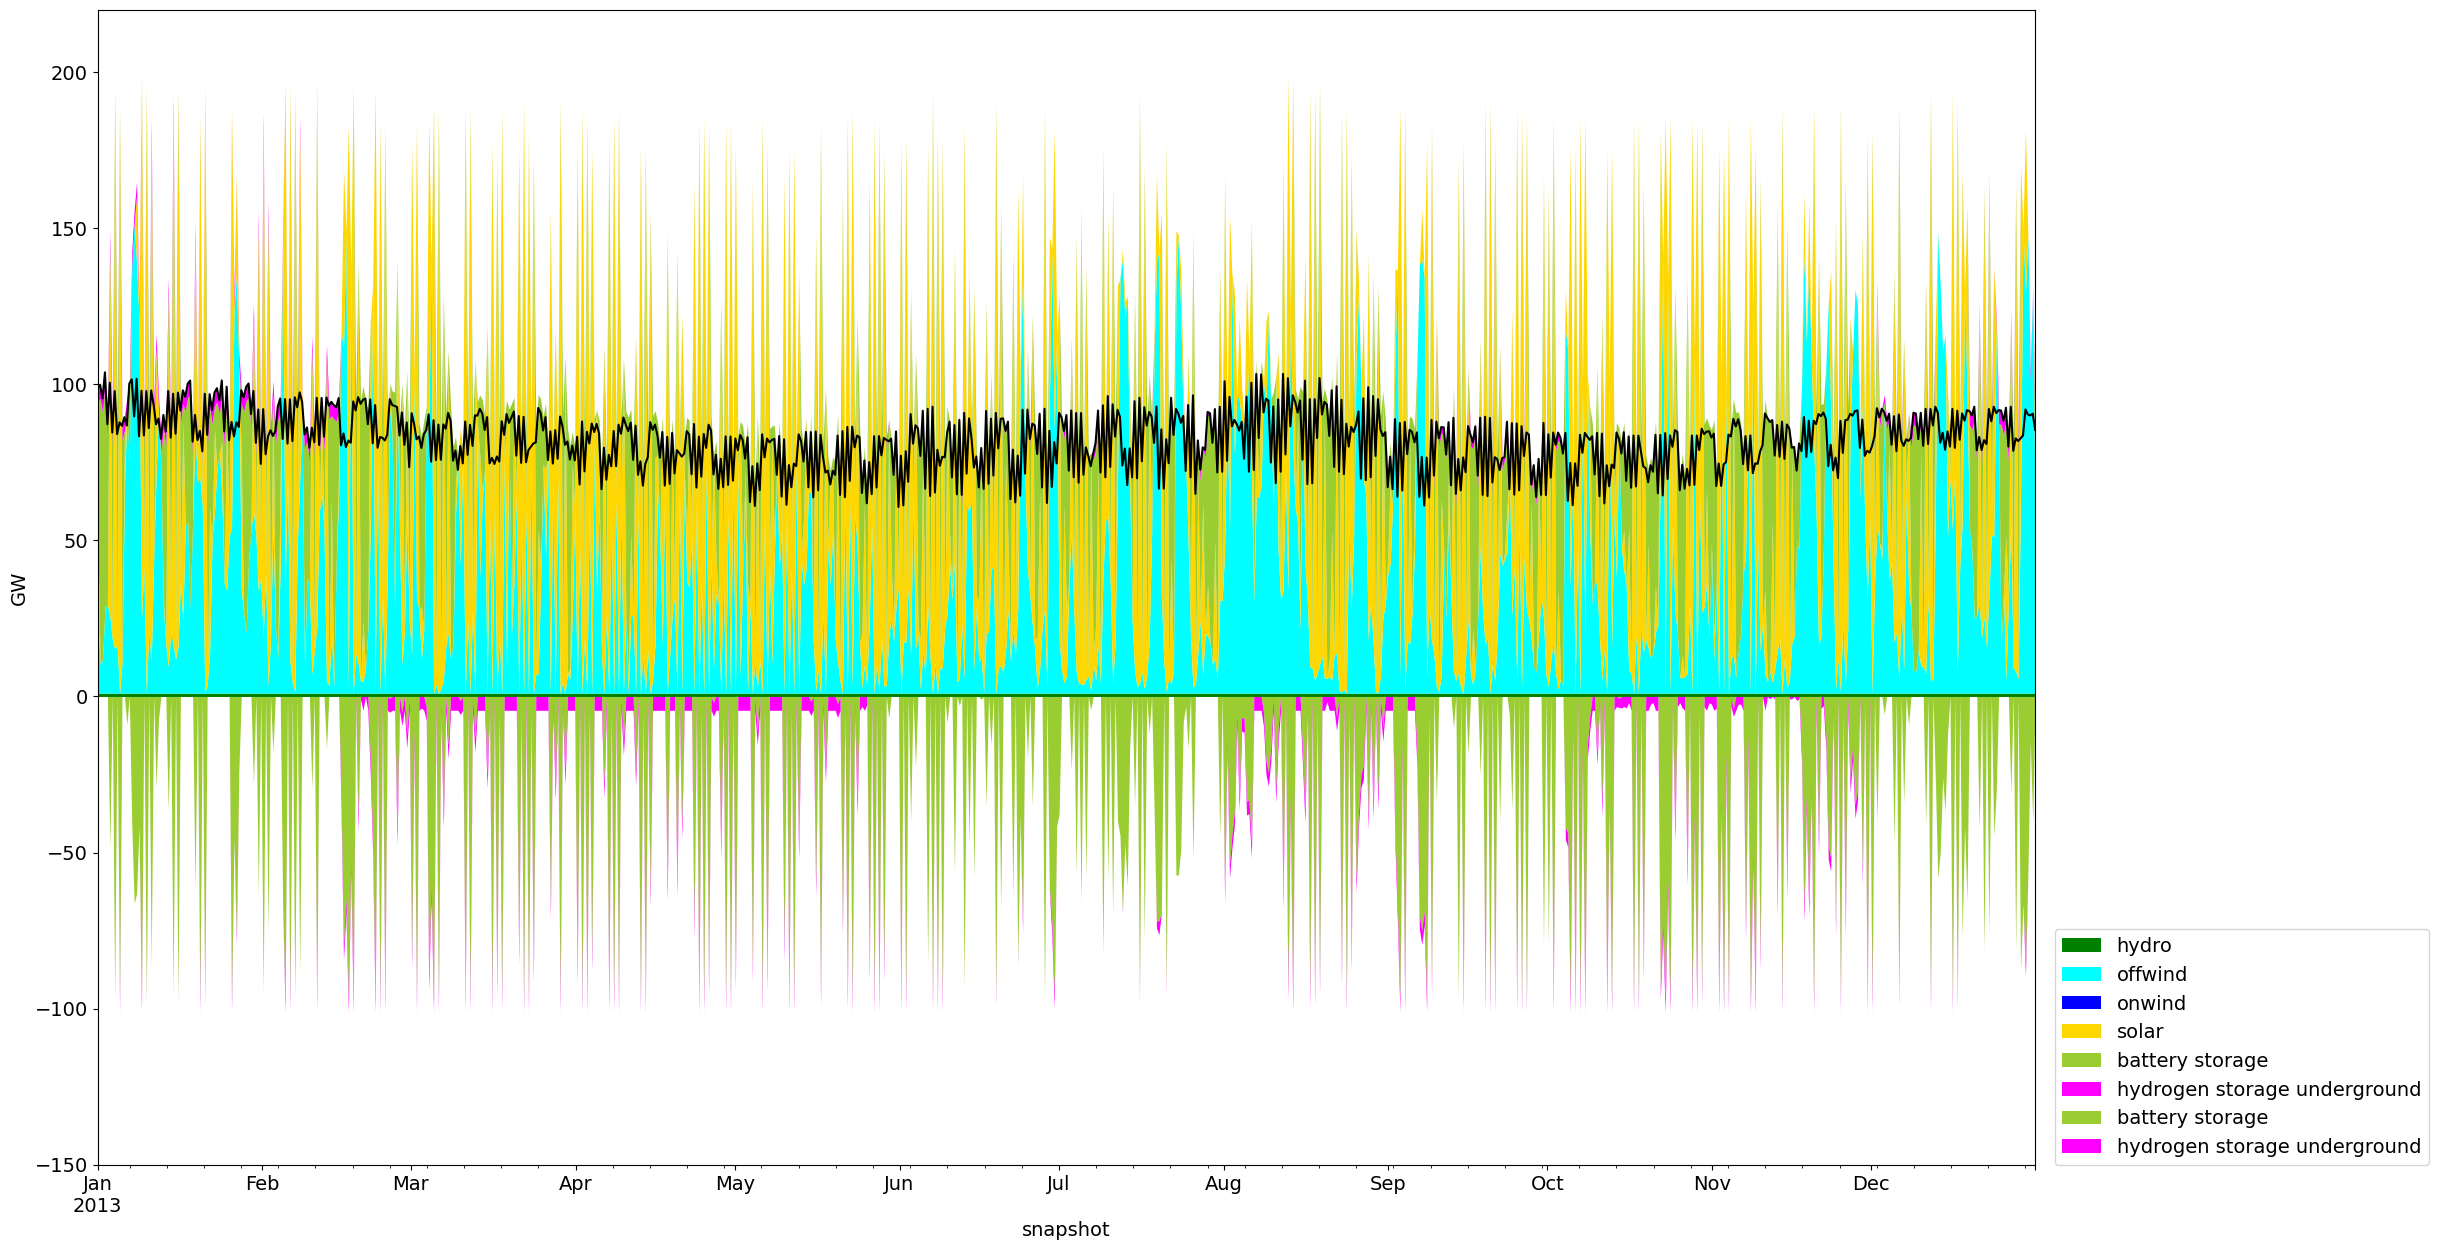

In [319]:
plot_dispatch(n2, "2013", -150, 220)

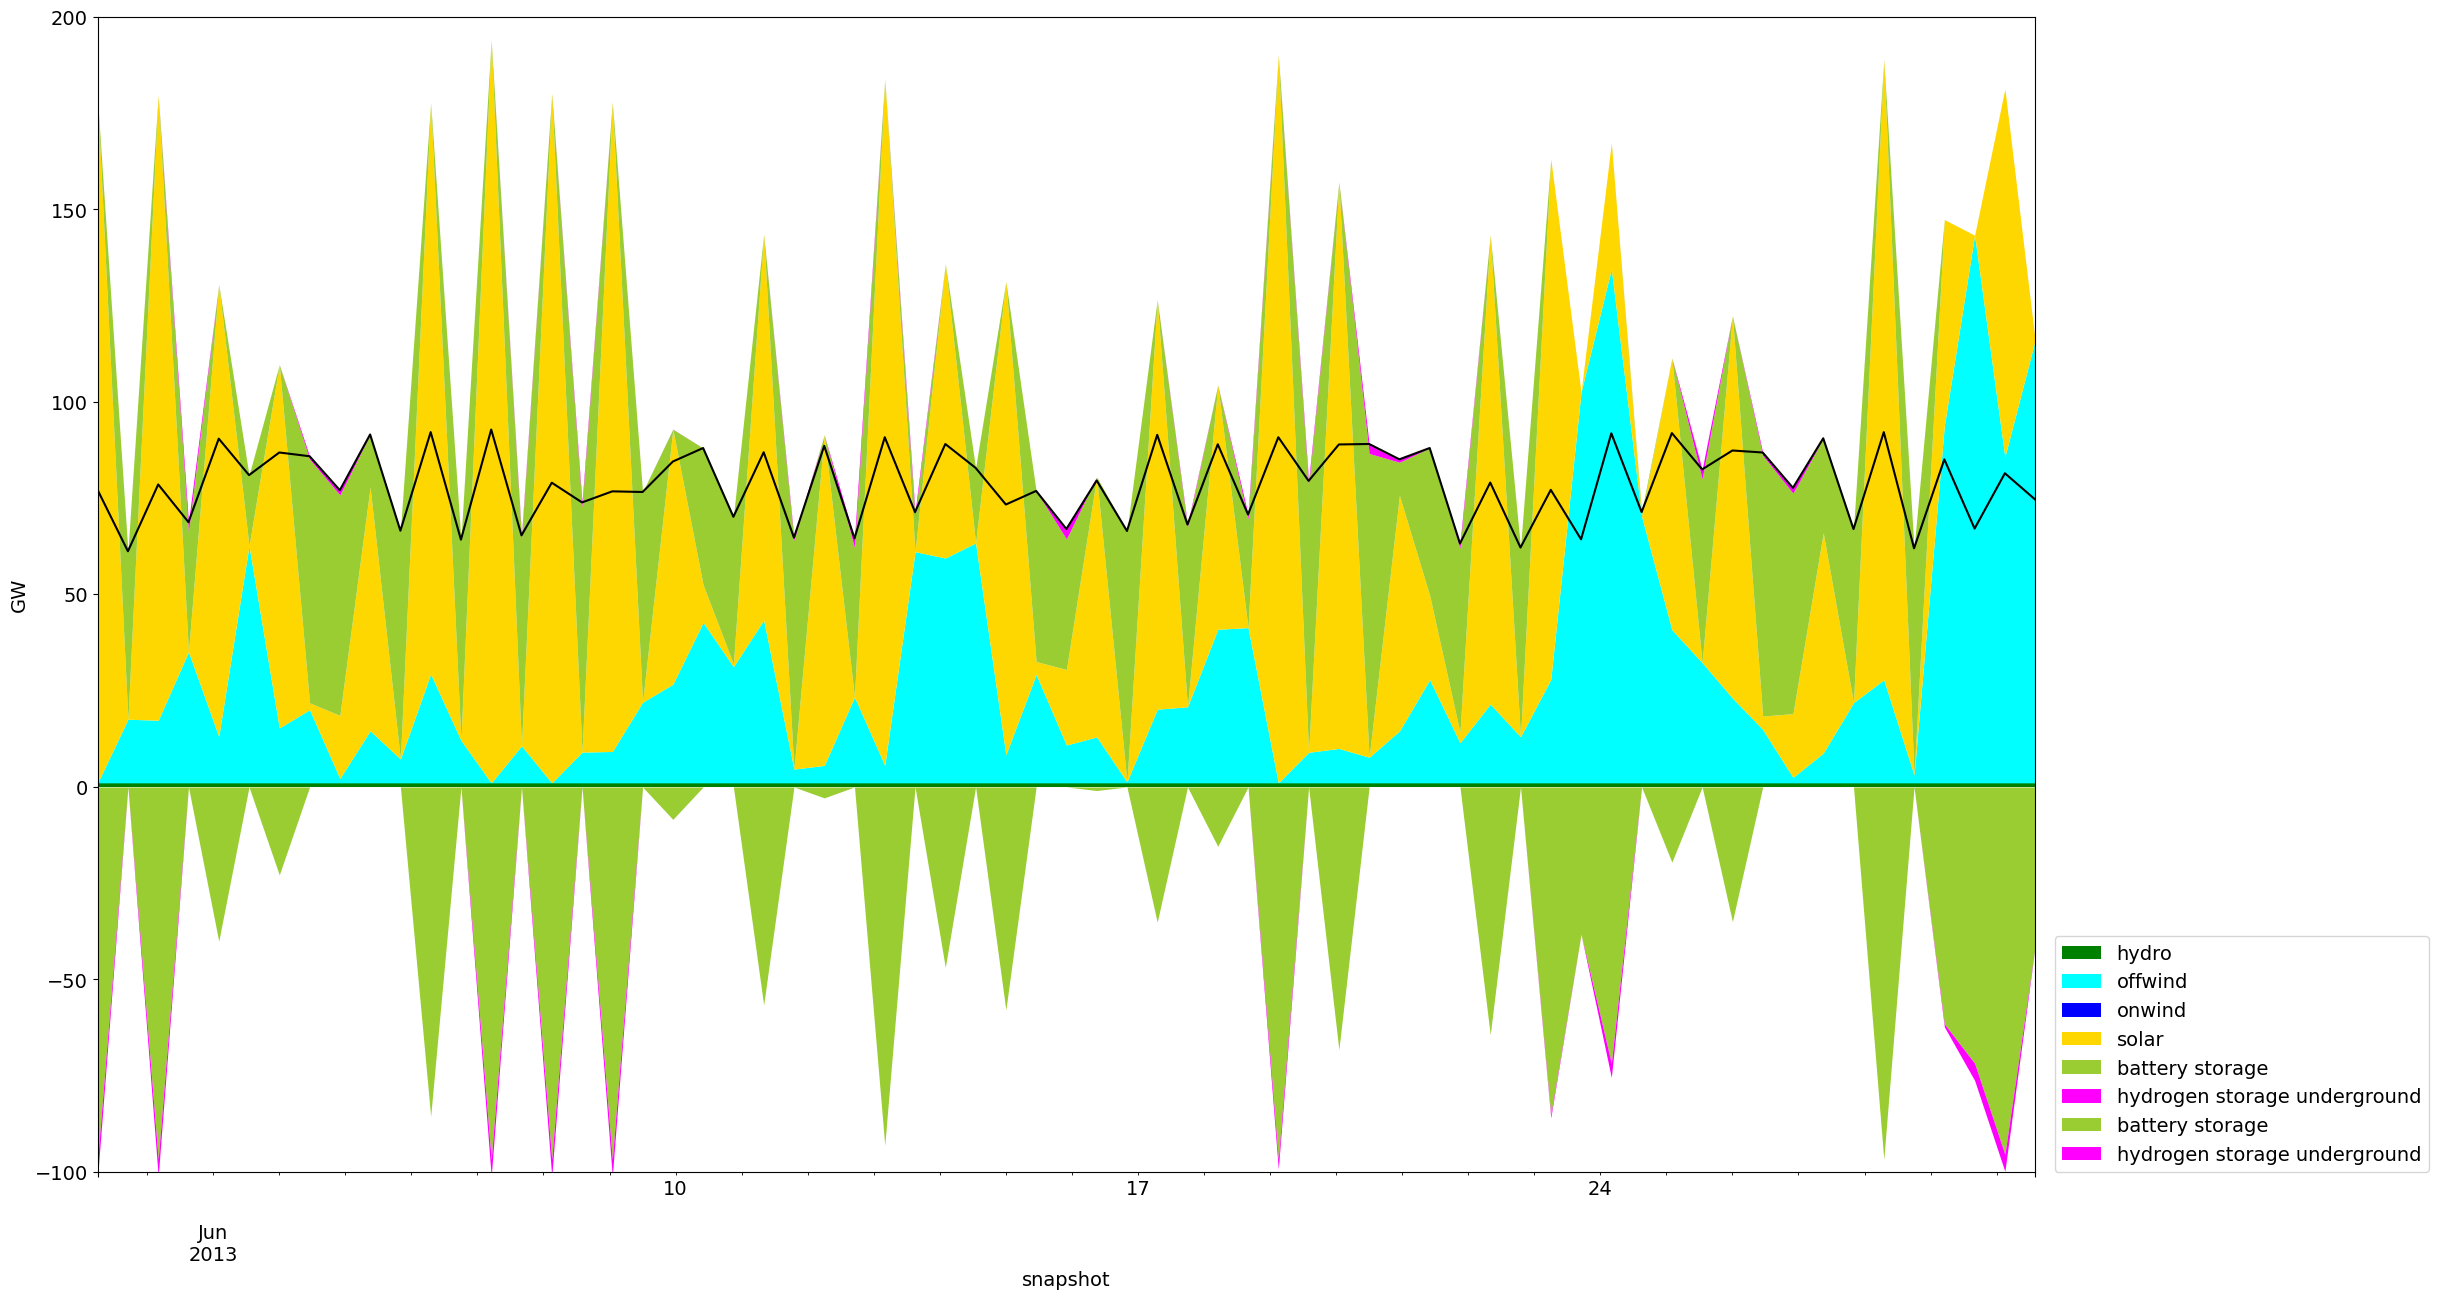

In [320]:
#system reactivity in when little wind is available
plot_dispatch(n2, "2013-06", -100, 200)

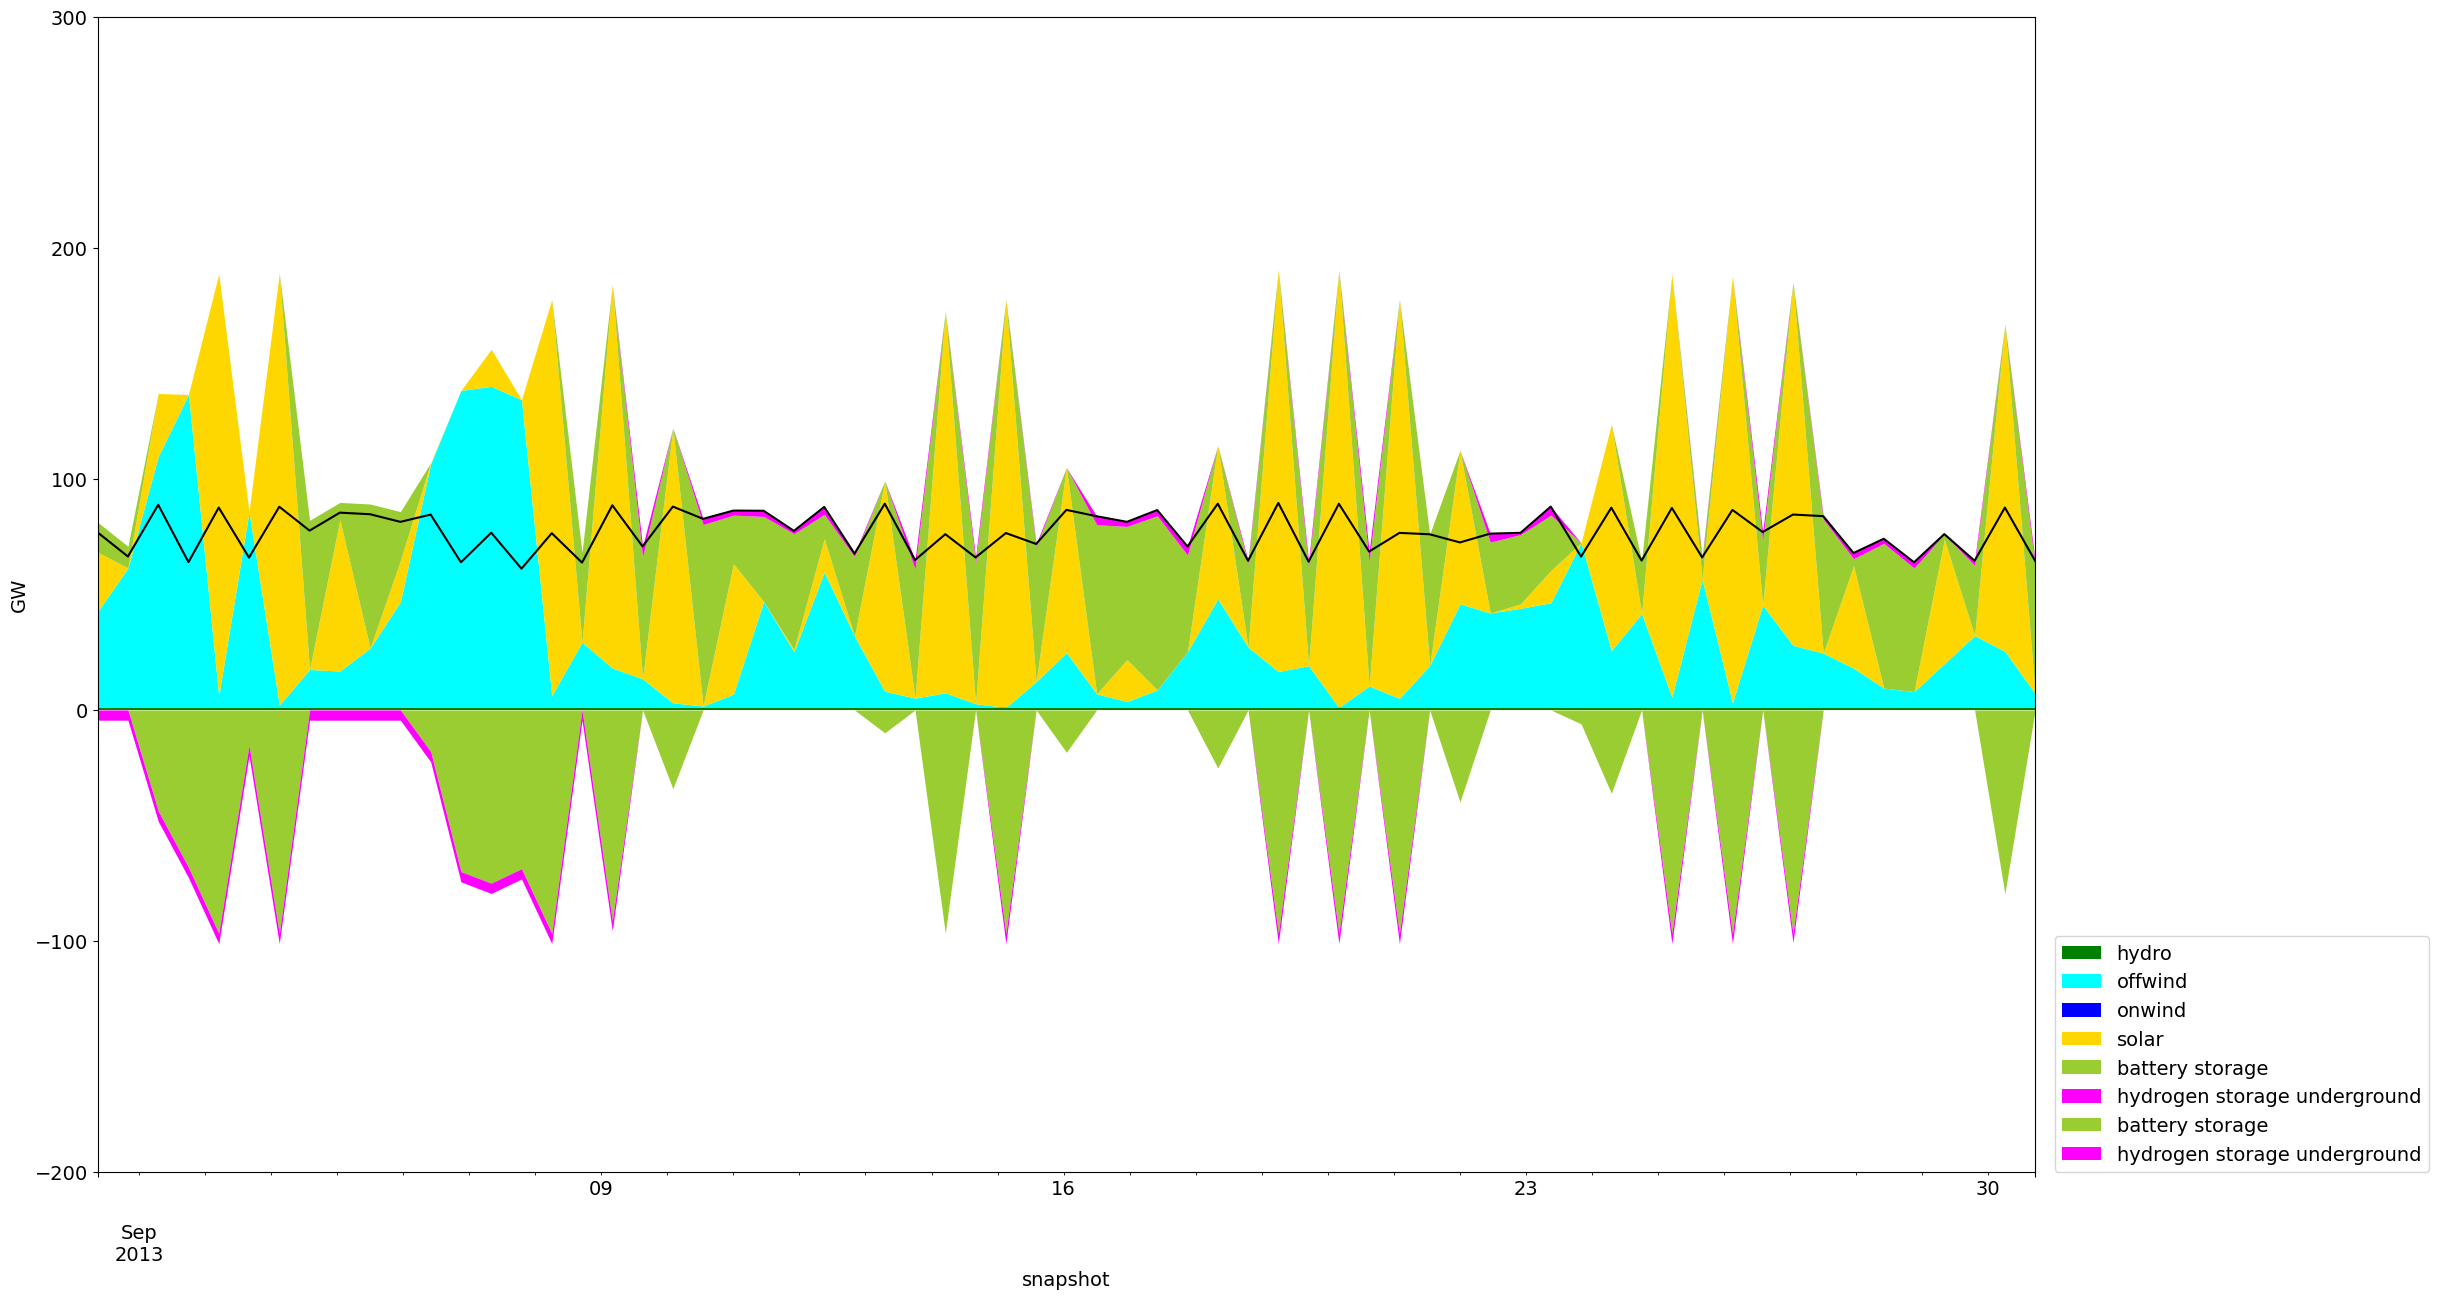

In [321]:
#system reactivity in when lots of wind is available
plot_dispatch(n2, "2013-09", -200, 300)

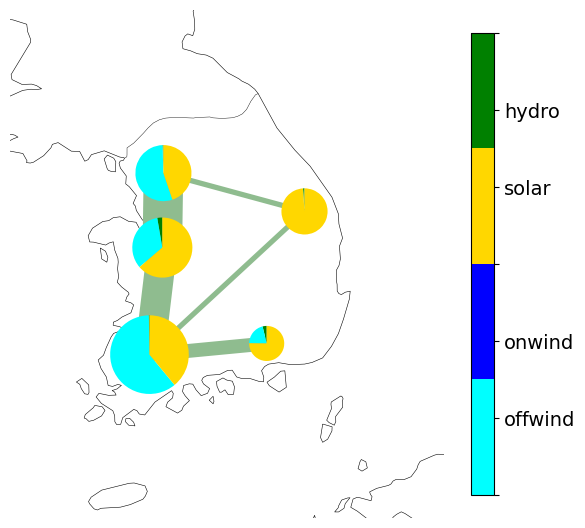

In [322]:
capacities = n2.generators_t.p.groupby([n2.generators.bus, n2.generators.carrier], axis = 1).sum().sum()
carriers = n2.generators.carrier.unique()
colorforcarriers = ["cyan","blue","gold","green"]
carrierforcolors = ["","offwind","onwind","","solar","hydro"]

fig = plt.figure(figsize=(7,10))
ax = plt.axes(projection=ccrs.epsg(4087))

norm = plt.Normalize(vmin=n2.links_t.p0.iloc[0].abs().min(), vmax=n2.links_t.p0.iloc[0].abs().max())

n2.plot(
    ax=ax,
    margin=0.9,
    bus_sizes=capacities / 5e7*0.5,
    link_norm=norm,
    link_cmap='jet',
    link_widths= n2.links_t.p0.iloc[0].abs() / 1e3
)

norm = mpl.colors.Normalize(vmin=1, vmax=4)

cmap = ListedColormap(colorforcarriers)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar = plt.colorbar(sm, ax=ax, shrink=0.6)
cbar.ax.set_yticklabels(carrierforcolors)


plt.rcParams.update({'font.size': 10})

<AxesSubplot: title={'center': 'Price Duration\xa0Curve'}, xlabel='frequency', ylabel='Cost [Eur]'>

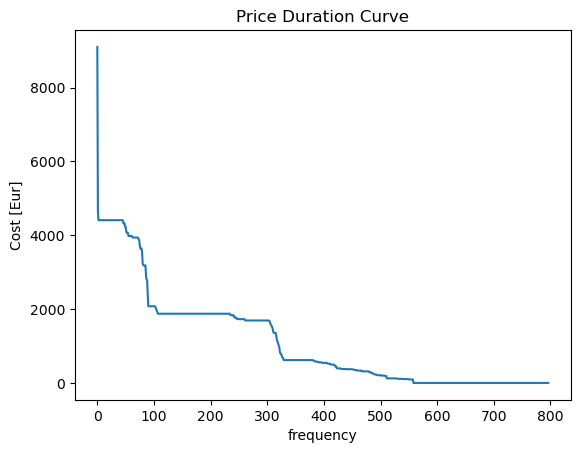

In [323]:
price_duration=n2.buses_t.marginal_price
price_duration=price_duration.mean(axis=1)
price_duration=price_duration.sort_values(ascending=False).reset_index(drop=True)
price_duration.plot(ylabel='Cost [Eur]', xlabel='frequency', title='Price Duration Curve')

(<matplotlib.collections.PatchCollection at 0x2406575e700>,
 <matplotlib.collections.LineCollection at 0x2406573a520>)

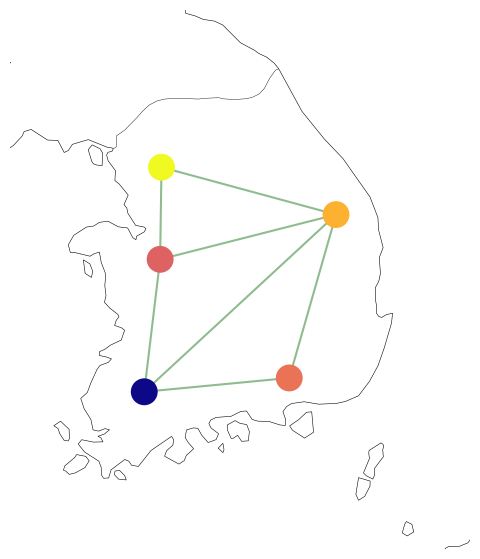

In [324]:
fig = plt.figure(figsize=(7,7))
ax = plt.axes(projection=ccrs.epsg(4087))

norm = plt.Normalize(vmin=n2.buses_t.marginal_price.mean().min(), vmax=n2.buses_t.marginal_price.mean().max()) # €/MWh

n2.plot(
    margin=0.7,
    ax=ax,
    bus_colors=n2.buses_t.marginal_price.mean(),
    bus_cmap='plasma',
    bus_norm=norm,
)

Text(0.5, 0, '2013')

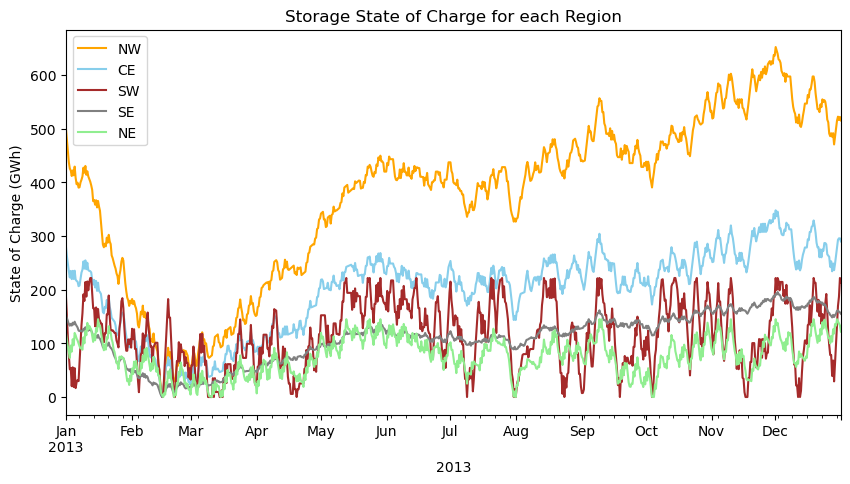

In [326]:
regioncolors = ["orange", "skyblue", "brown","grey", "lightgreen"]
i = 0
test = n2.storage_units_t.state_of_charge.groupby([n2.storage_units.bus], axis=1).sum()

fig, ax = plt.subplots(figsize=(10,5))

for region in region_names:
    x = test[region] / 1e3
    x.plot(color = regioncolors[i], label=region)
    i += 1

# plt.ylim(, 5)
plt.title('Storage State of Charge for each Region')
plt.legend(loc='upper left')
plt.ylabel('State of Charge (GWh)')
plt.xlabel('2013')

Text(0, 0.5, 'State of Charge (GWh)')

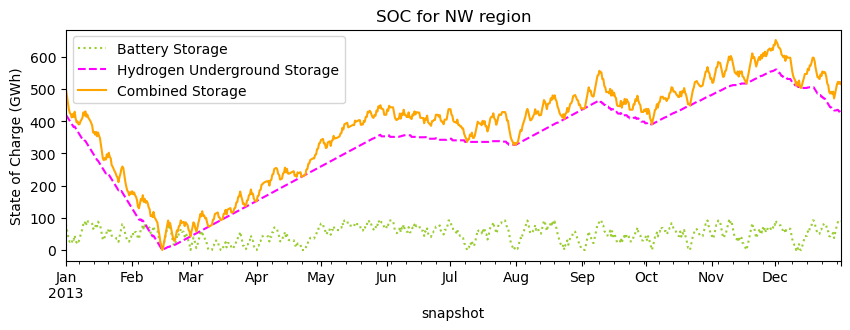

In [329]:
colordict = n.carriers.color.to_dict()
SW_battery = n2.storage_units_t.state_of_charge['battery storage NW'] / 1e3
SW_hydrogen = n2.storage_units_t.state_of_charge['hydrogen storage underground NW'] / 1e3
SW_combined = SW_battery + SW_hydrogen

fig, ax = plt.subplots(figsize=(10, 3))

SW_battery.plot(ax=ax, color=colordict['battery storage'], linestyle=':', label='Battery Storage')
SW_hydrogen.plot(ax=ax, color=colordict['hydrogen storage underground'], linestyle='--', label='Hydrogen Underground Storage')
SW_combined.plot(ax=ax, color='orange', label='Combined Storage')
ax.legend(loc='upper left')
ax.set_title('SOC for NW region')
ax.set_ylabel('State of Charge (GWh)')

In [330]:
demand = n2.snapshot_weightings.generators @ n2.loads_t.p_set.sum(axis=1)
n2_costperMW = system_cost(n2).sum()*1e6 / demand.sum()
print(f'Total system cost is € {round(system_cost(n2).sum()/ 1e3, 2)} Billion @ {round(n2_costperMW,1)} €/MWh')

Total system cost is € 74.46 Billion @ 1133.5 €/MWh


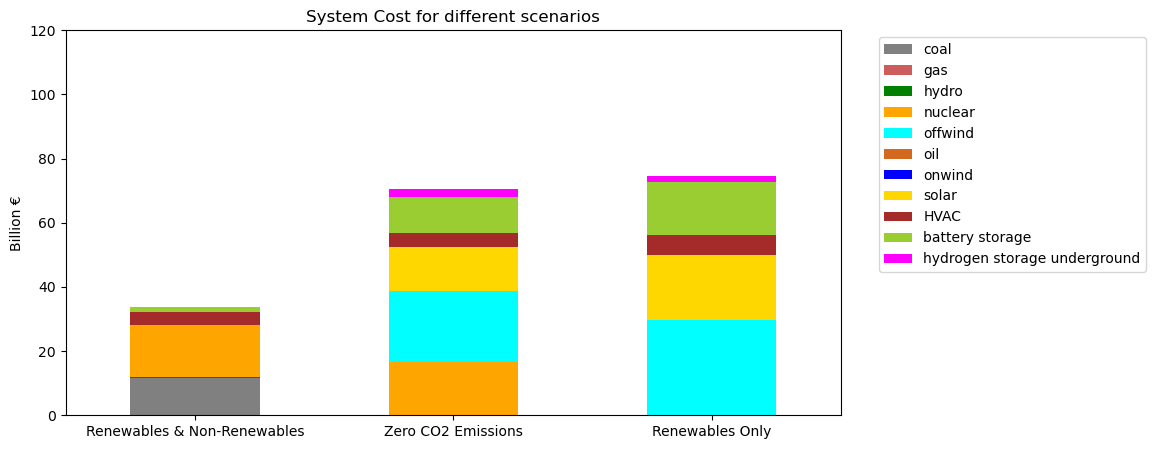

In [331]:
test = system_cost(n)
test2 = system_cost(n2)
test1 = system_cost(n1)
xyz = pd.DataFrame()
xyz['Renewables & Non-Renewables'] = test / 1e3
xyz["Zero CO2 Emissions"] = test1/1e3
xyz['Renewables Only'] = test2 / 1e3

xyz.T.plot.bar(stacked=True, figsize=(10,5), color=colordict)
plt.title('System Cost for different scenarios')
plt.xticks(rotation=0)
plt.ylabel('Billion €')
plt.ylim(0,120)
plt.legend(loc='best')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")


<a id='7'></a>
## 7 Sensitivity Analaysis. <font size=5>[&#x1F815;]()</font>

<a id='7.1'></a>
## 7.1 Variations of solar potentials <font size=5>[&#x1F815;]()</font>

In [217]:
n3 = n2.copy()

In [218]:
def system_cost_3(n):
    tsc = n.statistics.capex() + n.statistics.opex()
    return tsc.droplevel(0).div(1e6) # million €/a

In [226]:
cost_sensitivity_solar = {}
dispatch_sensitivity_solar = {}
for solar_potential in [0.1,0.2,0.4, 0.5, 0.8 , 1 , 1.5 , 2]:
    for i in range(1,6):
        temp_var = n3.generators.loc[f"solar {dict[i]}", "p_nom_max"]
        n3.generators.loc[f"solar {dict[i]}", "p_nom_max"] = solar_potential * n3.generators.loc[f"solar {dict[i]}", "p_nom_max"]
    n3.lopf(solver_name='gurobi')
    cost_sensitivity_solar[solar_potential] = system_cost_3(n3)
    dispatch_sensitivity_solar[solar_potential] = n3.generators.groupby("carrier").p_nom_opt.sum()
    for i in range(1,6):
        n3.generators.loc[f"solar {dict[i]}", "p_nom_max"] = temp_var

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.48s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\juliu\AppData\Local\Temp\pypsa-problem-igwb93fw.lp
Reading time = 0.18 seconds
obj: 102814 rows, 45462 columns, 210769 nonzeros
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: AMD Ryzen 7 5800U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 102814 rows, 45462 columns and 210769 nonzeros
Model fingerprint: 0x057b2c61
Coefficient statistics:
  Matrix range     [1e-06, 5e+02]
  Objective range  [1e-02, 4e+05]
  Bounds range     [9e+02, 9e+04]
  RHS range        [9e+01, 5e+04]
Presolve removed 45875 rows and 2040 columns
Presolve time: 0.11s
Presolved: 56939 rows, 43422 columns, 162964 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.01s

Barrier statistics:
 Dense cols : 32
 Free vars  : 5570
 AA' NZ     : 1.523e+05
 Factor NZ  : 8.383e+05 (roughly 5

INFO:pypsa.linopf:Optimization successful. Objective value: 1.52e+11
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.47s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\juliu\AppData\Local\Temp\pypsa-problem-gd88t4zn.lp
Reading time = 0.18 seconds
obj: 102814 rows, 45462 columns, 210769 nonzeros
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: AMD Ryzen 7 5800U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 102814 rows, 45462 columns and 210769 nonzeros
Model fingerprint: 0x01e84e94
Coefficient statistics:
  Matrix range     [1e-06, 5e+02]
  Objective range  [1e-02, 4e+05]
  Bounds range     [9e+02, 9e+04]
  RHS range        [9e+01, 5e+04]
Presolve removed 45875 rows and 2040 columns
Presolve time: 0.09s
Presolved: 56939 rows, 43422 columns, 162964 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 32
 Free vars  : 5570
 AA' NZ     : 1.523e+05
 Factor NZ  : 8.383e+05 (roughly 5

INFO:pypsa.linopf:Optimization successful. Objective value: 9.96e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.48s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\juliu\AppData\Local\Temp\pypsa-problem-8fkluaw9.lp
Reading time = 0.18 seconds
obj: 102814 rows, 45462 columns, 210769 nonzeros
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: AMD Ryzen 7 5800U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 102814 rows, 45462 columns and 210769 nonzeros
Model fingerprint: 0x7b4310e1
Coefficient statistics:
  Matrix range     [1e-06, 5e+02]
  Objective range  [1e-02, 4e+05]
  Bounds range     [9e+02, 9e+04]
  RHS range        [9e+01, 5e+04]
Presolve removed 45875 rows and 2040 columns
Presolve time: 0.09s
Presolved: 56939 rows, 43422 columns, 162964 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 32
 Free vars  : 5570
 AA' NZ     : 1.523e+05
 Factor NZ  : 8.383e+05 (roughly 5

INFO:pypsa.linopf:Optimization successful. Objective value: 8.46e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.48s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\juliu\AppData\Local\Temp\pypsa-problem-p0ea7sxw.lp
Reading time = 0.18 seconds
obj: 102814 rows, 45462 columns, 210769 nonzeros
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: AMD Ryzen 7 5800U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 102814 rows, 45462 columns and 210769 nonzeros
Model fingerprint: 0x5d6a804f
Coefficient statistics:
  Matrix range     [1e-06, 5e+02]
  Objective range  [1e-02, 4e+05]
  Bounds range     [9e+02, 9e+04]
  RHS range        [9e+01, 5e+04]
Presolve removed 45875 rows and 2040 columns
Presolve time: 0.09s
Presolved: 56939 rows, 43422 columns, 162964 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 32
 Free vars  : 5570
 AA' NZ     : 1.523e+05
 Factor NZ  : 8.383e+05 (roughly 5

INFO:pypsa.linopf:Optimization successful. Objective value: 8.03e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.51s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\juliu\AppData\Local\Temp\pypsa-problem-8134le8k.lp
Reading time = 0.18 seconds
obj: 102814 rows, 45462 columns, 210769 nonzeros
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: AMD Ryzen 7 5800U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 102814 rows, 45462 columns and 210769 nonzeros
Model fingerprint: 0x922373c7
Coefficient statistics:
  Matrix range     [1e-06, 5e+02]
  Objective range  [1e-02, 4e+05]
  Bounds range     [9e+02, 9e+04]
  RHS range        [9e+01, 5e+04]
Presolve removed 45875 rows and 2040 columns
Presolve time: 0.12s
Presolved: 56939 rows, 43422 columns, 162964 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 32
 Free vars  : 5570
 AA' NZ     : 1.523e+05
 Factor NZ  : 8.383e+05 (roughly 5

INFO:pypsa.linopf:Optimization successful. Objective value: 7.38e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.58s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\juliu\AppData\Local\Temp\pypsa-problem-9bkrvhla.lp
Reading time = 0.18 seconds
obj: 102814 rows, 45462 columns, 210769 nonzeros
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: AMD Ryzen 7 5800U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 102814 rows, 45462 columns and 210769 nonzeros
Model fingerprint: 0x27433e5e
Coefficient statistics:
  Matrix range     [1e-06, 5e+02]
  Objective range  [1e-02, 4e+05]
  Bounds range     [9e+02, 9e+04]
  RHS range        [9e+01, 5e+04]
Presolve removed 45875 rows and 2040 columns
Presolve time: 0.11s
Presolved: 56939 rows, 43422 columns, 162964 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 32
 Free vars  : 5570
 AA' NZ     : 1.523e+05
 Factor NZ  : 8.383e+05 (roughly 5

INFO:pypsa.linopf:Optimization successful. Objective value: 7.33e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.51s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\juliu\AppData\Local\Temp\pypsa-problem-429wyqkq.lp
Reading time = 0.19 seconds
obj: 102814 rows, 45462 columns, 210769 nonzeros
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: AMD Ryzen 7 5800U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 102814 rows, 45462 columns and 210769 nonzeros
Model fingerprint: 0x0c758b02
Coefficient statistics:
  Matrix range     [1e-06, 5e+02]
  Objective range  [1e-02, 4e+05]
  Bounds range     [9e+02, 1e+05]
  RHS range        [9e+01, 5e+04]
Presolve removed 45875 rows and 2040 columns
Presolve time: 0.11s
Presolved: 56939 rows, 43422 columns, 162964 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 32
 Free vars  : 5570
 AA' NZ     : 1.523e+05
 Factor NZ  : 8.383e+05 (roughly 5

INFO:pypsa.linopf:Optimization successful. Objective value: 7.27e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.52s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\juliu\AppData\Local\Temp\pypsa-problem-gic65ooa.lp
Reading time = 0.18 seconds
obj: 102814 rows, 45462 columns, 210769 nonzeros
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: AMD Ryzen 7 5800U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 102814 rows, 45462 columns and 210769 nonzeros
Model fingerprint: 0xefd5823e
Coefficient statistics:
  Matrix range     [1e-06, 5e+02]
  Objective range  [1e-02, 4e+05]
  Bounds range     [9e+02, 2e+05]
  RHS range        [9e+01, 5e+04]
Presolve removed 45875 rows and 2040 columns
Presolve time: 0.11s
Presolved: 56939 rows, 43422 columns, 162964 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 32
 Free vars  : 5570
 AA' NZ     : 1.523e+05
 Factor NZ  : 8.383e+05 (roughly 5

INFO:pypsa.linopf:Optimization successful. Objective value: 7.25e+10


Text(2.3, 82.41858232553194, 'avg load')

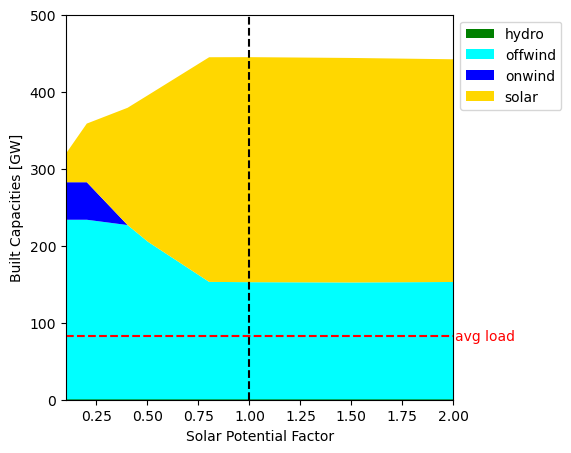

In [234]:
df = pd.DataFrame(dispatch_sensitivity_solar).T.div(1e3) # billion Euro/a
df.plot.area(
   stacked=True,
    linewidth=0,
    color=df.columns.map(n.carriers.color).dropna(),
    figsize=(5,5),
    xlim=(0.1,2),
    xlabel="Solar Potential Factor",
    ylabel="Built Capacities [GW]",
    ylim=(0,500),
)
plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
plt.axvline(x = 1, ls='--',color = 'black')
plt.axhline(y = load_ts.sum(axis = 1).mean()/1e3, ls = '--' , color = 'red')
plt.text(2.3, load_ts.sum(axis = 1).mean()/1e3, 'avg load', ha='right', va='center', color = "red")

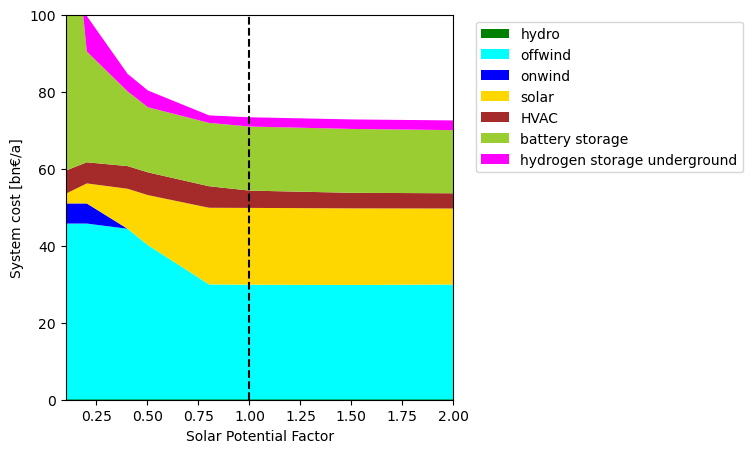

In [237]:
df = pd.DataFrame(cost_sensitivity_solar).T.div(1e3) # billion Euro/a
df.plot.area(
    stacked=True,
    linewidth=0,
    color=df.columns.map(n.carriers.color).dropna(),
    figsize=(5,5),
    xlim=(0.1,2),
    xlabel="Solar Potential Factor",
    ylabel="System cost [bn€/a]",
    ylim=(0,100),
)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.axvline(x = 1, ls='--',color = 'black')

<a id='7.2'></a>
## 7.2 Variations of offwind technology costs. <font size=5>[&#x1F815;]()</font>

In [238]:
n3 = n2.copy()

In [239]:
sensitivity_capex_off = {}
for capex_offwind in [5,2,1,0.8,0.6,0.4,0.2,0]:
    for i in range(1,6):
        temp_var =  n3.generators.loc[f"offwind {dict[i]}","capital_cost"]
        n3.generators.loc[f"offwind {dict[i]}","capital_cost"] = n3.generators.loc[f"offwind {dict[i]}","capital_cost"] * capex_offwind
    n3.lopf(solver_name='gurobi')
    sensitivity_capex_off[capex_offwind] = system_cost_3(n3)
    for i in range(1,6):
        n3.generators.loc[f"offwind {dict[i]}","capital_cost"] = temp_var

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.4s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\juliu\AppData\Local\Temp\pypsa-problem-in0ah6g7.lp
Reading time = 0.17 seconds
obj: 102814 rows, 45462 columns, 210769 nonzeros
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: AMD Ryzen 7 5800U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 102814 rows, 45462 columns and 210769 nonzeros
Model fingerprint: 0xd459dac2
Coefficient statistics:
  Matrix range     [1e-06, 5e+02]
  Objective range  [1e-02, 1e+06]
  Bounds range     [9e+02, 9e+04]
  RHS range        [9e+01, 5e+04]
Presolve removed 45875 rows and 2040 columns
Presolve time: 0.09s
Presolved: 56939 rows, 43422 columns, 162964 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 32
 Free vars  : 5570
 AA' NZ     : 1.523e+05
 Factor NZ  : 8.383e+05 (roughly 5

INFO:pypsa.linopf:Optimization successful. Objective value: 1.63e+11
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.5s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\juliu\AppData\Local\Temp\pypsa-problem-uvsx3y7l.lp
Reading time = 0.19 seconds
obj: 102814 rows, 45462 columns, 210769 nonzeros
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: AMD Ryzen 7 5800U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 102814 rows, 45462 columns and 210769 nonzeros
Model fingerprint: 0x0b434c0a
Coefficient statistics:
  Matrix range     [1e-06, 5e+02]
  Objective range  [1e-02, 4e+05]
  Bounds range     [9e+02, 9e+04]
  RHS range        [9e+01, 5e+04]
Presolve removed 45875 rows and 2040 columns
Presolve time: 0.12s
Presolved: 56939 rows, 43422 columns, 162964 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 32
 Free vars  : 5570
 AA' NZ     : 1.523e+05
 Factor NZ  : 8.383e+05 (roughly 5

INFO:pypsa.linopf:Optimization successful. Objective value: 1.00e+11
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.42s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\juliu\AppData\Local\Temp\pypsa-problem-u5szrtpq.lp
Reading time = 0.17 seconds
obj: 102814 rows, 45462 columns, 210769 nonzeros
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: AMD Ryzen 7 5800U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 102814 rows, 45462 columns and 210769 nonzeros
Model fingerprint: 0xac0e0e28
Coefficient statistics:
  Matrix range     [1e-06, 5e+02]
  Objective range  [1e-02, 4e+05]
  Bounds range     [9e+02, 9e+04]
  RHS range        [9e+01, 5e+04]
Presolve removed 45875 rows and 2040 columns
Presolve time: 0.09s
Presolved: 56939 rows, 43422 columns, 162964 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 32
 Free vars  : 5570
 AA' NZ     : 1.523e+05
 Factor NZ  : 8.383e+05 (roughly 5

INFO:pypsa.linopf:Optimization successful. Objective value: 7.43e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.44s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\juliu\AppData\Local\Temp\pypsa-problem-_0wxzg4y.lp
Reading time = 0.19 seconds
obj: 102814 rows, 45462 columns, 210769 nonzeros
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: AMD Ryzen 7 5800U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 102814 rows, 45462 columns and 210769 nonzeros
Model fingerprint: 0x67dd15e5
Coefficient statistics:
  Matrix range     [1e-06, 5e+02]
  Objective range  [1e-02, 4e+05]
  Bounds range     [9e+02, 9e+04]
  RHS range        [9e+01, 5e+04]
Presolve removed 45875 rows and 2040 columns
Presolve time: 0.14s
Presolved: 56939 rows, 43422 columns, 162964 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 32
 Free vars  : 5570
 AA' NZ     : 1.523e+05
 Factor NZ  : 8.383e+05 (roughly 5

INFO:pypsa.linopf:Optimization successful. Objective value: 6.80e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.43s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\juliu\AppData\Local\Temp\pypsa-problem-pf7r74z9.lp
Reading time = 0.17 seconds
obj: 102814 rows, 45462 columns, 210769 nonzeros
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: AMD Ryzen 7 5800U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 102814 rows, 45462 columns and 210769 nonzeros
Model fingerprint: 0xd3adc7c9
Coefficient statistics:
  Matrix range     [1e-06, 5e+02]
  Objective range  [1e-02, 4e+05]
  Bounds range     [9e+02, 9e+04]
  RHS range        [9e+01, 5e+04]
Presolve removed 45875 rows and 2040 columns
Presolve time: 0.11s
Presolved: 56939 rows, 43422 columns, 162964 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 32
 Free vars  : 5570
 AA' NZ     : 1.523e+05
 Factor NZ  : 8.383e+05 (roughly 5

INFO:pypsa.linopf:Optimization successful. Objective value: 6.13e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.48s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\juliu\AppData\Local\Temp\pypsa-problem-jf38z548.lp
Reading time = 0.18 seconds
obj: 102814 rows, 45462 columns, 210769 nonzeros
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: AMD Ryzen 7 5800U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 102814 rows, 45462 columns and 210769 nonzeros
Model fingerprint: 0xc58aa8a0
Coefficient statistics:
  Matrix range     [1e-06, 5e+02]
  Objective range  [1e-02, 4e+05]
  Bounds range     [9e+02, 9e+04]
  RHS range        [9e+01, 5e+04]
Presolve removed 45875 rows and 2040 columns
Presolve time: 0.13s
Presolved: 56939 rows, 43422 columns, 162964 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 32
 Free vars  : 5570
 AA' NZ     : 1.523e+05
 Factor NZ  : 8.383e+05 (roughly 5

INFO:pypsa.linopf:Optimization successful. Objective value: 5.38e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.46s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\juliu\AppData\Local\Temp\pypsa-problem-oy0nv8x1.lp
Reading time = 0.18 seconds
obj: 102814 rows, 45462 columns, 210769 nonzeros
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: AMD Ryzen 7 5800U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 102814 rows, 45462 columns and 210769 nonzeros
Model fingerprint: 0x2d668aee
Coefficient statistics:
  Matrix range     [1e-06, 5e+02]
  Objective range  [1e-02, 4e+05]
  Bounds range     [9e+02, 9e+04]
  RHS range        [9e+01, 5e+04]
Presolve removed 45875 rows and 2040 columns
Presolve time: 0.11s
Presolved: 56939 rows, 43422 columns, 162964 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 32
 Free vars  : 5570
 AA' NZ     : 1.523e+05
 Factor NZ  : 8.383e+05 (roughly 5

INFO:pypsa.linopf:Optimization successful. Objective value: 4.55e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.49s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\juliu\AppData\Local\Temp\pypsa-problem-a1oqxwt5.lp
Reading time = 0.18 seconds
obj: 102814 rows, 45462 columns, 210769 nonzeros
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: AMD Ryzen 7 5800U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 102814 rows, 45462 columns and 210769 nonzeros
Model fingerprint: 0xd1220c4c
Coefficient statistics:
  Matrix range     [1e-06, 5e+02]
  Objective range  [1e-02, 4e+05]
  Bounds range     [9e+02, 9e+04]
  RHS range        [9e+01, 5e+04]
Presolve removed 49850 rows and 2045 columns
Presolve time: 0.11s
Presolved: 52964 rows, 43417 columns, 155014 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 27
 Free vars  : 5570
 AA' NZ     : 1.443e+05
 Factor NZ  : 7.807e+05 (roughly 4

INFO:pypsa.linopf:Optimization successful. Objective value: 3.64e+10


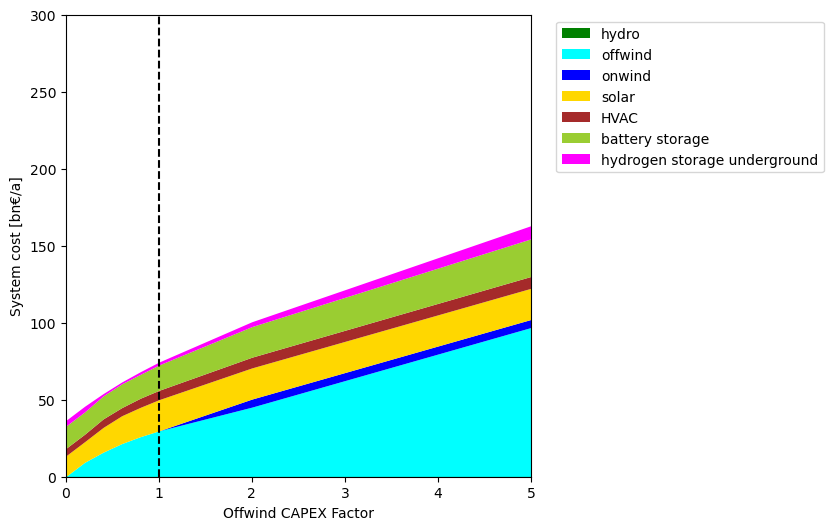

In [240]:
df1 = pd.DataFrame(sensitivity_capex_off).T.div(1e3) # billion Euro/a
df1.plot.area(
    stacked=True,
    linewidth=0,
    color=df1.columns.map(n.carriers.color).dropna(),
    figsize=(6,6),
    xlim=(0,5),
    xlabel="Offwind CAPEX Factor",
    ylabel="System cost [bn€/a]",
    ylim=(0,300),
)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.axvline(x = 1, ls='--',color = 'black')

In [241]:
sensitivity_capex_solar = {}
for capex_solar in [5,2,1,0.8,0.6,0.4,0.2,0]:
    for i in range(1,6):
        temp_var =  n3.generators.loc[f"solar {dict[i]}","capital_cost"]
        n3.generators.loc[f"solar {dict[i]}","capital_cost"] = n3.generators.loc[f"solar {dict[i]}","capital_cost"] * capex_solar
    n3.lopf(solver_name='gurobi')
    sensitivity_capex_solar[capex_solar] = system_cost_3(n3)
    for i in range(1,6):
        n3.generators.loc[f"solar {dict[i]}","capital_cost"] = temp_var

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.74s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\juliu\AppData\Local\Temp\pypsa-problem-53y4hj8t.lp
Reading time = 0.26 seconds
obj: 102814 rows, 45462 columns, 210769 nonzeros
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: AMD Ryzen 7 5800U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 102814 rows, 45462 columns and 210769 nonzeros
Model fingerprint: 0x7ed1d0d2
Coefficient statistics:
  Matrix range     [1e-06, 5e+02]
  Objective range  [1e-02, 4e+05]
  Bounds range     [9e+02, 9e+04]
  RHS range        [9e+01, 5e+04]
Presolve removed 45875 rows and 2040 columns
Presolve time: 0.09s
Presolved: 56939 rows, 43422 columns, 162964 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 32
 Free vars  : 5570
 AA' NZ     : 1.523e+05
 Factor NZ  : 8.383e+05 (roughly 5

INFO:pypsa.linopf:Optimization successful. Objective value: 1.19e+11
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.42s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\juliu\AppData\Local\Temp\pypsa-problem-m1da0jvw.lp
Reading time = 0.17 seconds
obj: 102814 rows, 45462 columns, 210769 nonzeros
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: AMD Ryzen 7 5800U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 102814 rows, 45462 columns and 210769 nonzeros
Model fingerprint: 0x354e38d4
Coefficient statistics:
  Matrix range     [1e-06, 5e+02]
  Objective range  [1e-02, 4e+05]
  Bounds range     [9e+02, 9e+04]
  RHS range        [9e+01, 5e+04]
Presolve removed 45875 rows and 2040 columns
Presolve time: 0.10s
Presolved: 56939 rows, 43422 columns, 162964 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 32
 Free vars  : 5570
 AA' NZ     : 1.523e+05
 Factor NZ  : 8.383e+05 (roughly 5

INFO:pypsa.linopf:Optimization successful. Objective value: 9.21e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.47s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\juliu\AppData\Local\Temp\pypsa-problem-_td3h1vx.lp
Reading time = 0.17 seconds
obj: 102814 rows, 45462 columns, 210769 nonzeros
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: AMD Ryzen 7 5800U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 102814 rows, 45462 columns and 210769 nonzeros
Model fingerprint: 0xac0e0e28
Coefficient statistics:
  Matrix range     [1e-06, 5e+02]
  Objective range  [1e-02, 4e+05]
  Bounds range     [9e+02, 9e+04]
  RHS range        [9e+01, 5e+04]
Presolve removed 45875 rows and 2040 columns
Presolve time: 0.10s
Presolved: 56939 rows, 43422 columns, 162964 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 32
 Free vars  : 5570
 AA' NZ     : 1.523e+05
 Factor NZ  : 8.383e+05 (roughly 5

INFO:pypsa.linopf:Optimization successful. Objective value: 7.43e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.47s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\juliu\AppData\Local\Temp\pypsa-problem-wpveoiqn.lp
Reading time = 0.18 seconds
obj: 102814 rows, 45462 columns, 210769 nonzeros
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: AMD Ryzen 7 5800U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 102814 rows, 45462 columns and 210769 nonzeros
Model fingerprint: 0xdded87c5
Coefficient statistics:
  Matrix range     [1e-06, 5e+02]
  Objective range  [1e-02, 4e+05]
  Bounds range     [9e+02, 9e+04]
  RHS range        [9e+01, 5e+04]
Presolve removed 45875 rows and 2040 columns
Presolve time: 0.10s
Presolved: 56939 rows, 43422 columns, 162964 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 32
 Free vars  : 5570
 AA' NZ     : 1.523e+05
 Factor NZ  : 8.383e+05 (roughly 5

INFO:pypsa.linopf:Optimization successful. Objective value: 7.02e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.42s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\juliu\AppData\Local\Temp\pypsa-problem-kec_24v2.lp
Reading time = 0.17 seconds
obj: 102814 rows, 45462 columns, 210769 nonzeros
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: AMD Ryzen 7 5800U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 102814 rows, 45462 columns and 210769 nonzeros
Model fingerprint: 0x06c070c3
Coefficient statistics:
  Matrix range     [1e-06, 5e+02]
  Objective range  [1e-02, 4e+05]
  Bounds range     [9e+02, 9e+04]
  RHS range        [9e+01, 5e+04]
Presolve removed 45875 rows and 2040 columns
Presolve time: 0.13s
Presolved: 56939 rows, 43422 columns, 162964 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 32
 Free vars  : 5570
 AA' NZ     : 1.523e+05
 Factor NZ  : 8.383e+05 (roughly 5

INFO:pypsa.linopf:Optimization successful. Objective value: 6.62e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.42s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\juliu\AppData\Local\Temp\pypsa-problem-6cgssjdh.lp
Reading time = 0.17 seconds
obj: 102814 rows, 45462 columns, 210769 nonzeros
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: AMD Ryzen 7 5800U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 102814 rows, 45462 columns and 210769 nonzeros
Model fingerprint: 0xc63605cd
Coefficient statistics:
  Matrix range     [1e-06, 5e+02]
  Objective range  [1e-02, 4e+05]
  Bounds range     [9e+02, 9e+04]
  RHS range        [9e+01, 5e+04]
Presolve removed 45875 rows and 2040 columns
Presolve time: 0.10s
Presolved: 56939 rows, 43422 columns, 162964 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 32
 Free vars  : 5570
 AA' NZ     : 1.523e+05
 Factor NZ  : 8.383e+05 (roughly 5

INFO:pypsa.linopf:Optimization successful. Objective value: 6.21e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.43s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\juliu\AppData\Local\Temp\pypsa-problem-die9rjri.lp
Reading time = 0.18 seconds
obj: 102814 rows, 45462 columns, 210769 nonzeros
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: AMD Ryzen 7 5800U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 102814 rows, 45462 columns and 210769 nonzeros
Model fingerprint: 0xfdca888a
Coefficient statistics:
  Matrix range     [1e-06, 5e+02]
  Objective range  [1e-02, 4e+05]
  Bounds range     [9e+02, 9e+04]
  RHS range        [9e+01, 5e+04]
Presolve removed 45875 rows and 2040 columns
Presolve time: 0.10s
Presolved: 56939 rows, 43422 columns, 162964 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 32
 Free vars  : 5570
 AA' NZ     : 1.523e+05
 Factor NZ  : 8.383e+05 (roughly 5

INFO:pypsa.linopf:Optimization successful. Objective value: 5.81e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.45s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\juliu\AppData\Local\Temp\pypsa-problem-lzmc7vs8.lp
Reading time = 0.18 seconds
obj: 102814 rows, 45462 columns, 210769 nonzeros
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: AMD Ryzen 7 5800U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 102814 rows, 45462 columns and 210769 nonzeros
Model fingerprint: 0xdcfde2df
Coefficient statistics:
  Matrix range     [1e-06, 5e+02]
  Objective range  [1e-02, 4e+05]
  Bounds range     [9e+02, 9e+04]
  RHS range        [9e+01, 5e+04]
Presolve removed 47868 rows and 2045 columns
Presolve time: 0.10s
Presolved: 54946 rows, 43417 columns, 158978 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.01s

Barrier statistics:
 Dense cols : 27
 Free vars  : 5570
 AA' NZ     : 1.483e+05
 Factor NZ  : 7.908e+05 (roughly 5

INFO:pypsa.linopf:Optimization successful. Objective value: 5.40e+10


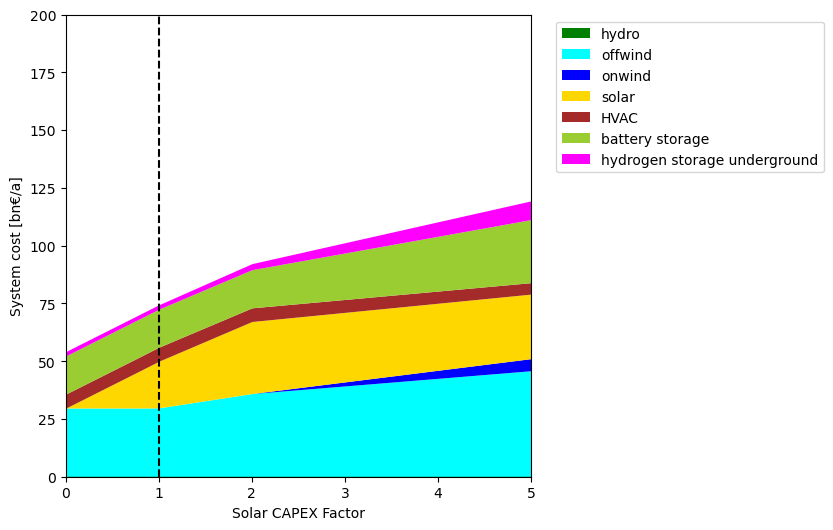

In [243]:
df2 = pd.DataFrame(sensitivity_capex_solar).T.div(1e3) # billion Euro/a
df2.plot.area(
    stacked=True,
    linewidth=0,
    color=df2.columns.map(n.carriers.color).dropna(),
    figsize=(6,6),
    xlim=(0,5),
    xlabel="Solar CAPEX Factor",
    ylabel="System cost [bn€/a]",
    ylim=(0,200),
)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.axvline(x = 1, ls='--',color = 'black')

<a id='7.3'></a>
## 7.3 Variations of nuclear cost <font size=5>[&#x1F815;]()</font>

In [244]:
n3 = n2.copy()

In [245]:
for i in range(1,6):
    n3.add(
            "Generator",
            f"nuclear {region_names[i-1]}",
            bus=f'{region_names[i-1]}',
            carrier="nuclear",
            capital_cost=costs.at["nuclear", "capital_cost"],
            marginal_cost=costs.at["nuclear", "marginal_cost"],
            efficiency=costs.at["nuclear", "efficiency"],
            p_nom_extendable=True,
        )

In [246]:
sensitivity_capex_nuclear = {}
dispatch_sensitivity_nuclear = {}
for capex_nuclear in [5,2,1,0.8,0.6,0.4,0.2,0]:
    for i in range(1,6):
        temp_var =  n3.generators.loc[f"nuclear {dict[i]}","capital_cost"]
        n3.generators.loc[f"nuclear {dict[i]}","capital_cost"] = n3.generators.loc[f"nuclear {dict[i]}","capital_cost"] * capex_nuclear
    n3.lopf(solver_name='gurobi')
    dispatch_sensitivity_nuclear[capex_nuclear] = n3.generators.groupby("carrier").p_nom_opt.sum()
    sensitivity_capex_nuclear[capex_nuclear] = system_cost_3(n3)
    for i in range(1,6):
        n3.generators.loc[f"nuclear {dict[i]}","capital_cost"] = temp_var

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.43s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\juliu\AppData\Local\Temp\pypsa-problem-5wqna4st.lp
Reading time = 0.18 seconds
obj: 110784 rows, 49452 columns, 226709 nonzeros
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: AMD Ryzen 7 5800U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 110784 rows, 49452 columns and 226709 nonzeros
Model fingerprint: 0x7cc9888f
Coefficient statistics:
  Matrix range     [1e-06, 5e+02]
  Objective range  [1e-02, 4e+06]
  Bounds range     [9e+02, 9e+04]
  RHS range        [9e+01, 5e+04]
Presolve removed 49851 rows and 2031 columns
Presolve time: 0.10s
Presolved: 60933 rows, 47421 columns, 174829 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 37
 Free vars  : 5579
 AA' NZ     : 1.601e+05
 Factor NZ  : 8.735e+05 (roughly 5

INFO:pypsa.linopf:Optimization successful. Objective value: 7.43e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.5s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\juliu\AppData\Local\Temp\pypsa-problem-1ma7_t2n.lp
Reading time = 0.20 seconds
obj: 110784 rows, 49452 columns, 226709 nonzeros
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: AMD Ryzen 7 5800U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 110784 rows, 49452 columns and 226709 nonzeros
Model fingerprint: 0xc4431929
Coefficient statistics:
  Matrix range     [1e-06, 5e+02]
  Objective range  [1e-02, 1e+06]
  Bounds range     [9e+02, 9e+04]
  RHS range        [9e+01, 5e+04]
Presolve removed 49851 rows and 2031 columns
Presolve time: 0.10s
Presolved: 60933 rows, 47421 columns, 174829 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 37
 Free vars  : 5579
 AA' NZ     : 1.601e+05
 Factor NZ  : 8.735e+05 (roughly 5

INFO:pypsa.linopf:Optimization successful. Objective value: 7.43e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.45s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\juliu\AppData\Local\Temp\pypsa-problem-hla_w67z.lp
Reading time = 0.19 seconds
obj: 110784 rows, 49452 columns, 226709 nonzeros
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: AMD Ryzen 7 5800U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 110784 rows, 49452 columns and 226709 nonzeros
Model fingerprint: 0x0e2e1f83
Coefficient statistics:
  Matrix range     [1e-06, 5e+02]
  Objective range  [1e-02, 7e+05]
  Bounds range     [9e+02, 9e+04]
  RHS range        [9e+01, 5e+04]
Presolve removed 49851 rows and 2031 columns
Presolve time: 0.10s
Presolved: 60933 rows, 47421 columns, 174829 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.01s

Barrier statistics:
 Dense cols : 37
 Free vars  : 5579
 AA' NZ     : 1.601e+05
 Factor NZ  : 8.735e+05 (roughly 5

INFO:pypsa.linopf:Optimization successful. Objective value: 6.40e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.45s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\juliu\AppData\Local\Temp\pypsa-problem-qlznripb.lp
Reading time = 0.19 seconds
obj: 110784 rows, 49452 columns, 226709 nonzeros
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: AMD Ryzen 7 5800U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 110784 rows, 49452 columns and 226709 nonzeros
Model fingerprint: 0x4098c92b
Coefficient statistics:
  Matrix range     [1e-06, 5e+02]
  Objective range  [1e-02, 6e+05]
  Bounds range     [9e+02, 9e+04]
  RHS range        [9e+01, 5e+04]
Presolve removed 49851 rows and 2031 columns
Presolve time: 0.10s
Presolved: 60933 rows, 47421 columns, 174829 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 37
 Free vars  : 5579
 AA' NZ     : 1.601e+05
 Factor NZ  : 8.735e+05 (roughly 5

INFO:pypsa.linopf:Optimization successful. Objective value: 5.31e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.45s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\juliu\AppData\Local\Temp\pypsa-problem-whjff1yk.lp
Reading time = 0.19 seconds
obj: 110784 rows, 49452 columns, 226709 nonzeros
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: AMD Ryzen 7 5800U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 110784 rows, 49452 columns and 226709 nonzeros
Model fingerprint: 0xcafb1bd9
Coefficient statistics:
  Matrix range     [1e-06, 5e+02]
  Objective range  [1e-02, 4e+05]
  Bounds range     [9e+02, 9e+04]
  RHS range        [9e+01, 5e+04]
Presolve removed 49851 rows and 2031 columns
Presolve time: 0.10s
Presolved: 60933 rows, 47421 columns, 174829 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 37
 Free vars  : 5579
 AA' NZ     : 1.601e+05
 Factor NZ  : 8.735e+05 (roughly 5

INFO:pypsa.linopf:Optimization successful. Objective value: 4.11e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.46s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\juliu\AppData\Local\Temp\pypsa-problem-dnf6tgb6.lp
Reading time = 0.20 seconds
obj: 110784 rows, 49452 columns, 226709 nonzeros
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: AMD Ryzen 7 5800U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 110784 rows, 49452 columns and 226709 nonzeros
Model fingerprint: 0xa71fc0e0
Coefficient statistics:
  Matrix range     [1e-06, 5e+02]
  Objective range  [1e-02, 4e+05]
  Bounds range     [9e+02, 9e+04]
  RHS range        [9e+01, 5e+04]
Presolve removed 49851 rows and 2031 columns
Presolve time: 0.11s
Presolved: 60933 rows, 47421 columns, 174829 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 37
 Free vars  : 5579
 AA' NZ     : 1.601e+05
 Factor NZ  : 8.735e+05 (roughly 5

INFO:pypsa.linopf:Optimization successful. Objective value: 2.84e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.48s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\juliu\AppData\Local\Temp\pypsa-problem-kufh6gw_.lp
Reading time = 0.19 seconds
obj: 110784 rows, 49452 columns, 226709 nonzeros
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: AMD Ryzen 7 5800U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 110784 rows, 49452 columns and 226709 nonzeros
Model fingerprint: 0xafcc6554
Coefficient statistics:
  Matrix range     [1e-06, 5e+02]
  Objective range  [1e-02, 4e+05]
  Bounds range     [9e+02, 9e+04]
  RHS range        [9e+01, 5e+04]
Presolve removed 49851 rows and 2031 columns
Presolve time: 0.11s
Presolved: 60933 rows, 47421 columns, 174829 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 37
 Free vars  : 5579
 AA' NZ     : 1.601e+05
 Factor NZ  : 8.735e+05 (roughly 5

INFO:pypsa.linopf:Optimization successful. Objective value: 1.53e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.5s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\juliu\AppData\Local\Temp\pypsa-problem-d7kv3zwh.lp
Reading time = 0.21 seconds
obj: 110784 rows, 49452 columns, 226709 nonzeros
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: AMD Ryzen 7 5800U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 110784 rows, 49452 columns and 226709 nonzeros
Model fingerprint: 0xe74e2b8f
Coefficient statistics:
  Matrix range     [1e-06, 5e+02]
  Objective range  [1e-02, 4e+05]
  Bounds range     [9e+02, 9e+04]
  RHS range        [9e+01, 5e+04]
Presolve removed 53836 rows and 2036 columns
Presolve time: 0.11s
Presolved: 56948 rows, 47416 columns, 166859 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 32
 Free vars  : 5579
 AA' NZ     : 1.522e+05
 Factor NZ  : 8.387e+05 (roughly 5

INFO:pypsa.linopf:Optimization successful. Objective value: 7.38e+08


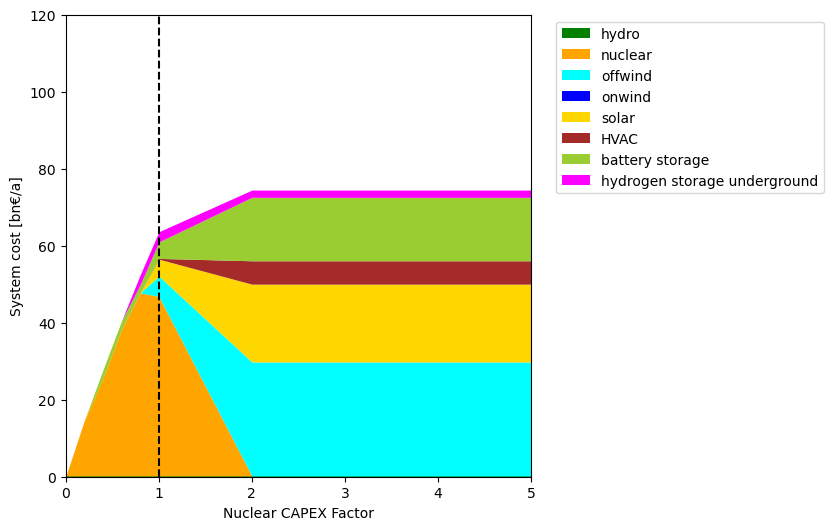

In [247]:
df3 = pd.DataFrame(sensitivity_capex_nuclear).T.div(1e3) # billion Euro/a
df3.plot.area(
    stacked=True,
    linewidth=0,
    color=df3.columns.map(n.carriers.color).dropna(),
    figsize=(6,6),
    xlim=(0,5),
    xlabel="Nuclear CAPEX Factor",
    ylabel="System cost [bn€/a]",
    ylim=(0,120),
)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.axvline(x = 1, ls='--',color = 'black')

Text(3, 82.41858232553194, 'avg load')

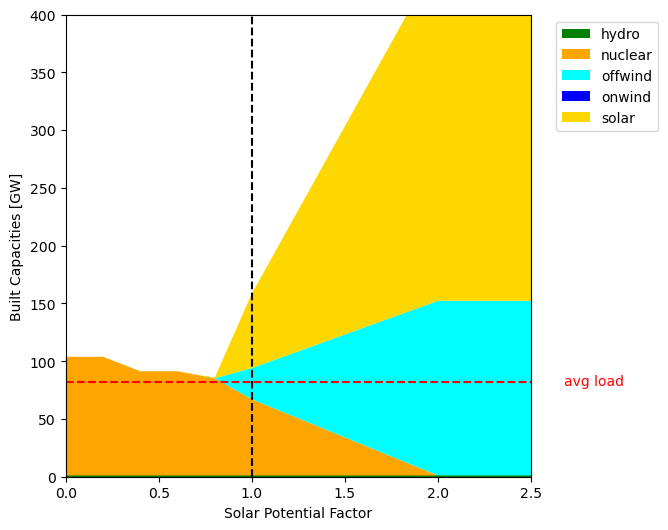

In [332]:
df3 = pd.DataFrame(dispatch_sensitivity_nuclear).T.div(1e3) # billion Euro/a
df3.plot.area(
    stacked=True,
    linewidth=0,
    color=df3.columns.map(n.carriers.color).dropna(),
    figsize=(6,6),
    xlim=(0,2.5),
    xlabel="Solar Potential Factor",
    ylabel="Built Capacities [GW]",
    ylim=(0,400),
)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.axvline(x = 1, ls='--',color = 'black')
plt.axhline(y = load_ts.sum(axis = 1).mean()/1e3, ls = '--' , color = 'red')
plt.text(3, load_ts.sum(axis = 1).mean()/1e3, 'avg load', ha='right', va='center', color = "red")

<a id='7.4'></a>
## 7.4 Variations of grid capacities. <font size=5>[&#x1F815;]()</font>

In [249]:
for i in range(1,6):
    n3.remove("Generator",f"nuclear {dict[i]}")

In [340]:
sensitivity_grid = {}
for grid_expansion in [10000,5000,4000,3000,2800,2700,2600]:
    for i in range(1,7):
        n3.links.iloc[i, 10] = grid_expansion
    n3.lopf(solver_name='gurobi')
    sensitivity_grid[grid_expansion] = system_cost(n3)

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.84s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\juliu\AppData\Local\Temp\pypsa-problem-frkcrt8l.lp
Reading time = 0.17 seconds
obj: 102814 rows, 45462 columns, 210769 nonzeros
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: AMD Ryzen 7 5800U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 102814 rows, 45462 columns and 210769 nonzeros
Model fingerprint: 0xcce9ba6a
Coefficient statistics:
  Matrix range     [1e-06, 5e+02]
  Objective range  [1e-02, 4e+05]
  Bounds range     [9e+02, 9e+04]
  RHS range        [9e+01, 5e+04]
Presolve removed 45875 rows and 2040 columns
Presolve time: 0.09s
Presolved: 56939 rows, 43422 columns, 162964 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 32
 Free vars  : 788
 AA' NZ     : 1.523e+05
 Factor NZ  : 8.383e+05 (roughly 50

INFO:pypsa.linopf:Optimization successful. Objective value: 7.45e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.46s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\juliu\AppData\Local\Temp\pypsa-problem-2yoy_kid.lp
Reading time = 0.17 seconds
obj: 102814 rows, 45462 columns, 210769 nonzeros
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: AMD Ryzen 7 5800U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 102814 rows, 45462 columns and 210769 nonzeros
Model fingerprint: 0x42884407
Coefficient statistics:
  Matrix range     [1e-06, 5e+02]
  Objective range  [1e-02, 4e+05]
  Bounds range     [9e+02, 9e+04]
  RHS range        [9e+01, 5e+04]
Presolve removed 45875 rows and 2040 columns
Presolve time: 0.10s
Presolved: 56939 rows, 43422 columns, 162964 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 32
 Free vars  : 788
 AA' NZ     : 1.523e+05
 Factor NZ  : 8.383e+05 (roughly 50

INFO:pypsa.linopf:Optimization successful. Objective value: 7.58e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.47s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\juliu\AppData\Local\Temp\pypsa-problem-7xji0qdn.lp
Reading time = 0.17 seconds
obj: 102814 rows, 45462 columns, 210769 nonzeros
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: AMD Ryzen 7 5800U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 102814 rows, 45462 columns and 210769 nonzeros
Model fingerprint: 0xc2f1265f
Coefficient statistics:
  Matrix range     [1e-06, 5e+02]
  Objective range  [1e-02, 4e+05]
  Bounds range     [9e+02, 9e+04]
  RHS range        [9e+01, 5e+04]
Presolve removed 45875 rows and 2040 columns
Presolve time: 0.09s
Presolved: 56939 rows, 43422 columns, 162964 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 32
 Free vars  : 788
 AA' NZ     : 1.523e+05
 Factor NZ  : 8.383e+05 (roughly 50

INFO:pypsa.linopf:Optimization successful. Objective value: 7.64e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.47s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\juliu\AppData\Local\Temp\pypsa-problem-p312f2zg.lp
Reading time = 0.17 seconds
obj: 102814 rows, 45462 columns, 210769 nonzeros
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: AMD Ryzen 7 5800U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 102814 rows, 45462 columns and 210769 nonzeros
Model fingerprint: 0x8360dd20
Coefficient statistics:
  Matrix range     [1e-06, 5e+02]
  Objective range  [1e-02, 4e+05]
  Bounds range     [9e+02, 9e+04]
  RHS range        [9e+01, 5e+04]
Presolve removed 45875 rows and 2040 columns
Presolve time: 0.09s
Presolved: 56939 rows, 43422 columns, 162964 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 32
 Free vars  : 788
 AA' NZ     : 1.523e+05
 Factor NZ  : 8.383e+05 (roughly 50

INFO:pypsa.linopf:Optimization successful. Objective value: 7.78e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.58s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\juliu\AppData\Local\Temp\pypsa-problem-nbjsl4wi.lp
Reading time = 0.17 seconds
obj: 102814 rows, 45462 columns, 210769 nonzeros
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: AMD Ryzen 7 5800U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 102814 rows, 45462 columns and 210769 nonzeros
Model fingerprint: 0xce76803a
Coefficient statistics:
  Matrix range     [1e-06, 5e+02]
  Objective range  [1e-02, 4e+05]
  Bounds range     [9e+02, 9e+04]
  RHS range        [9e+01, 5e+04]
Presolve removed 45875 rows and 2040 columns
Presolve time: 0.09s
Presolved: 56939 rows, 43422 columns, 162964 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 32
 Free vars  : 788
 AA' NZ     : 1.523e+05
 Factor NZ  : 8.383e+05 (roughly 50

INFO:pypsa.linopf:Optimization successful. Objective value: 8.01e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.79s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\juliu\AppData\Local\Temp\pypsa-problem-uf2edmeb.lp
Reading time = 0.25 seconds
obj: 102814 rows, 45462 columns, 210769 nonzeros
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: AMD Ryzen 7 5800U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 102814 rows, 45462 columns and 210769 nonzeros
Model fingerprint: 0x46a4abec
Coefficient statistics:
  Matrix range     [1e-06, 5e+02]
  Objective range  [1e-02, 4e+05]
  Bounds range     [9e+02, 9e+04]
  RHS range        [9e+01, 5e+04]
Presolve removed 45875 rows and 2040 columns
Presolve time: 0.10s
Presolved: 56939 rows, 43422 columns, 162964 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 32
 Free vars  : 788
 AA' NZ     : 1.523e+05
 Factor NZ  : 8.383e+05 (roughly 50

INFO:pypsa.linopf:Optimization successful. Objective value: 8.33e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.56s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\juliu\AppData\Local\Temp\pypsa-problem-pbkf_nv2.lp
Reading time = 0.18 seconds
obj: 102814 rows, 45462 columns, 210769 nonzeros
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: AMD Ryzen 7 5800U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 102814 rows, 45462 columns and 210769 nonzeros
Model fingerprint: 0xde4e43c3
Coefficient statistics:
  Matrix range     [1e-06, 5e+02]
  Objective range  [1e-02, 4e+05]
  Bounds range     [9e+02, 9e+04]
  RHS range        [9e+01, 5e+04]
Presolve removed 45875 rows and 2040 columns
Presolve time: 0.12s
Presolved: 56939 rows, 43422 columns, 162964 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 32
 Free vars  : 788
 AA' NZ     : 1.523e+05
 Factor NZ  : 8.383e+05 (roughly 50

INFO:pypsa.linopf:Optimization successful. Objective value: 8.65e+10


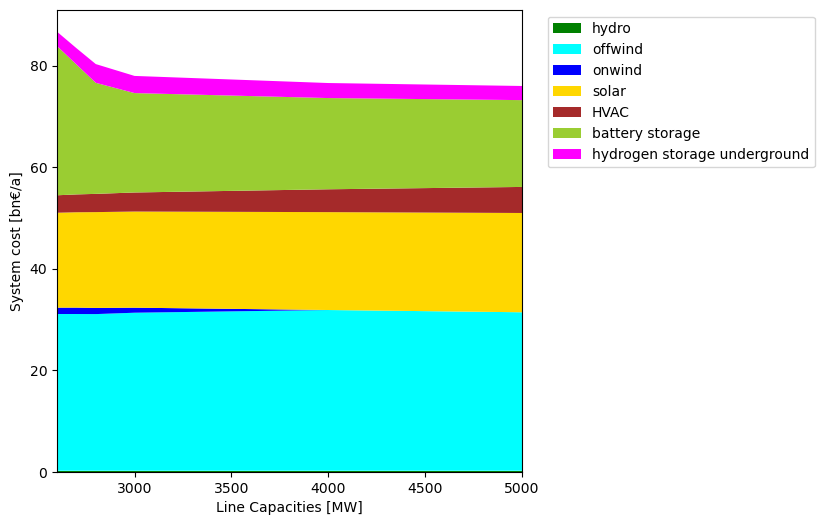

In [347]:
df4 = pd.DataFrame(sensitivity_grid).T.div(1e3) # billion Euro/a
df4.plot.area(
    stacked=True,
    linewidth=0,
    color=df4.columns.map(n.carriers.color).dropna(),
    figsize=(6,6),
    xlim=(2600,5000),
    xlabel="Line Capacities [MW]",
    ylabel="System cost [bn€/a]",
    #ylim=(0,200),
)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")